<a href="https://colab.research.google.com/github/vietnoir/BnB_Berlin_vs_Munich/blob/main/AirBnB_BerlinvsMunich.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Basic Libraries ---
import pandas as pd
import numpy as np
import os  # For file path and system operations
import warnings  # For suppressing warnings

# --- Visualization ---
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
!pip install catppuccin
import catppuccin
!pip install pywaffle
from pywaffle import Waffle
!pip install wordcloud
from wordcloud import WordCloud
import geopandas as gpd
import folium
from folium.plugins import StripePattern
import json

# --- NLP ---
!pip install gender-guesser # identifying gender by names
import gender_guesser.detector as gender
import re # manipulating strings
!pip install langid # detect a language
import langid
!pip install langdetect # detect a language
from langdetect import detect, DetectorFactory
!pip install deep_translator # translate listings names
from deep_translator import GoogleTranslator
import time # batch translation
from collections import Counter # count frequent words

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=7ae6dc925b69f2c4bcc829ebf0e3821d3345c950943fd41c3323bf40dc8af7e6
  Stored in directory: /root/.cache/pip/wheels/32/6a/b6/b7eb43a6ad55b139c15c5daa29f3707659cfa6944d3c696f5b
Successfully built langid
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=312da112d31a238b39d5287cdc6bf03f69af1321e694246e54efd16eabcf1ee0
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
   ━━━━━━━━━━━━━

# Reading in the Data

Data sourced from Inside Airbnb (https://insideairbnb.com), accessed on 28/02/2025.

Data not republished in adherence to data policy.

Data used for personal purposes.

In [2]:
# --- Google Colab Utilities (if working in Google Colab) ---
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define file paths
berlin_listings_path = "/content/drive/My Drive/AirBnB_BerlinvsMunich/Berlin/listings_b.csv"
munich_listings_path = "/content/drive/My Drive/AirBnB_BerlinvsMunich/Munich/listings_m.csv"
berlin_neighb_path = "/content/drive/My Drive/AirBnB_BerlinvsMunich/Berlin/neighbourhoods_b.csv"
munich_neighb_path = "/content/drive/My Drive/AirBnB_BerlinvsMunich/Munich/neighbourhoods_m.csv"
berlin_reviews_path = "/content/drive/My Drive/AirBnB_BerlinvsMunich/Berlin/reviews_b.csv"
munich_reviews_path = "/content/drive/My Drive/AirBnB_BerlinvsMunich/Munich/reviews_m.csv"
berlin_calendar_m = "/content/drive/My Drive/AirBnB_BerlinvsMunich/Munich/calendar_m.csv"
munich_calendar_path = "/content/drive/My Drive/AirBnB_BerlinvsMunich/Berlin/calendar_b.csv"

berlin_listings = pd.read_csv(berlin_listings_path)
munich_listings = pd.read_csv(munich_listings_path)
berlin_neighbourhoods = pd.read_csv(berlin_neighb_path)
munich_neighbourhoods = pd.read_csv(munich_neighb_path)
berlin_reviews = pd.read_csv(berlin_reviews_path)
munich_reviews = pd.read_csv(munich_reviews_path)
berlin_calendar = pd.read_csv(berlin_calendar_m)
munich_calendar = pd.read_csv(munich_calendar_path)

Mounted at /content/drive


# Listings

## Data Cleaning

In [3]:
# merging listings dataframes
# Add a column to distinguish between cities
berlin_listings["city"] = "Berlin"
munich_listings["city"] = "Munich"

# Concatenate both datasets into one
listings = pd.concat([berlin_listings, munich_listings], ignore_index=True)

# Display shape & first few rows
print("Merged Data Shape:", listings.shape)
listings.head()

Merged Data Shape: (21265, 19)


id                                           name  host_id  \
0   3176                Fabulous Flat in great Location     3718   
1   9991            Geourgeous flat - outstanding views    33852   
2  14325            Studio Apartment in Prenzlauer Berg    55531   
3  16644             In the Heart of Berlin - Kreuzberg    64696   
4  17904  Beautiful Kreuzberg studio - 3 months minimum    68997   

        host_name       neighbourhood_group             neighbourhood  \
0          Britta                    Pankow   Prenzlauer Berg Südwest   
1         Philipp                    Pankow   Prenzlauer Berg Südwest   
2  Chris + Oliver                    Pankow  Prenzlauer Berg Nordwest   
3            Rene  Friedrichshain-Kreuzberg     nördliche Luisenstadt   
4        Matthias                  Neukölln              Reuterstraße   

   latitude  longitude        room_type  price  minimum_nights  \
0  52.53471   13.41810  Entire home/apt   95.0              63   
1  52.53269   13.41805  Entire home/apt  180.0               6   
2  52.54813   13.40366  Entire home/apt   75.0             150   
3  52.50312   13.43508  Entire home/apt   90.0              93   
4  52.49419   13.42166  Entire home/apt   28.0              92   

   number_of_reviews last_review  reviews_per_month  \
0                148  2023-05-25               0.78   
1                  7  2020-01-04               0.06   
2                 26  2023-11-30               0.15   
3                 48  2017-12-14               0.27   
4                299  2022-12-01               1.65   

   calculated_host_listings_count  availability_365  number_of_reviews_ltm  \
0                               1               293                      0   
1                               1                43                      0   
2                               4                91                      0   
3                               2               111                      0   
4                               1                29                      0   

                                             license    city  
0  First name and Last name: Nicolas Krotz <br/> ...  Berlin  
1                                  03/Z/RA/003410-18  Berlin  
2                                                NaN  Berlin  
3                                                NaN  Berlin  
4                                                NaN  Berlin

In [4]:
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21265 entries, 0 to 21264
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              21265 non-null  int64  
 1   name                            21265 non-null  object 
 2   host_id                         21265 non-null  int64  
 3   host_name                       21254 non-null  object 
 4   neighbourhood_group             13984 non-null  object 
 5   neighbourhood                   21265 non-null  object 
 6   latitude                        21265 non-null  float64
 7   longitude                       21265 non-null  float64
 8   room_type                       21265 non-null  object 
 9   price                           13717 non-null  float64
 10  minimum_nights                  21265 non-null  int64  
 11  number_of_reviews               21265 non-null  int64  
 12  last_review                     

In [5]:
# Check missing values
print("Missing values in listings dataset:")
print(listings.isnull().sum())

Missing values in listings dataset:
id                                    0
name                                  0
host_id                               0
host_name                            11
neighbourhood_group                7281
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                              7548
minimum_nights                        0
number_of_reviews                     0
last_review                        4657
reviews_per_month                  4657
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           12400
city                                  0
dtype: int64


In [6]:
# neighbourhood and neighbourhood_group: The df berlin is divided into detailed neighbourhoods, with neighbourhood-groups being equivalent to the neighbourhoods in the munich df
# drop berlin neighbourhood, rename neighbourhood_group to neighbourhood
berlin_listings.drop('neighbourhood', axis = 1, inplace=True)
berlin_listings.rename(columns={'neighbourhood_group': 'neighbourhood'}, inplace=True)
munich_listings.drop('neighbourhood_group', axis = 1, inplace=True)

# Concatenate both datasets into one
listings = pd.concat([berlin_listings, munich_listings], ignore_index=True)
listings.head()

id                                           name  host_id  \
0   3176                Fabulous Flat in great Location     3718   
1   9991            Geourgeous flat - outstanding views    33852   
2  14325            Studio Apartment in Prenzlauer Berg    55531   
3  16644             In the Heart of Berlin - Kreuzberg    64696   
4  17904  Beautiful Kreuzberg studio - 3 months minimum    68997   

        host_name             neighbourhood  latitude  longitude  \
0          Britta                    Pankow  52.53471   13.41810   
1         Philipp                    Pankow  52.53269   13.41805   
2  Chris + Oliver                    Pankow  52.54813   13.40366   
3            Rene  Friedrichshain-Kreuzberg  52.50312   13.43508   
4        Matthias                  Neukölln  52.49419   13.42166   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt   95.0              63                148  2023-05-25   
1  Entire home/apt  180.0               6                  7  2020-01-04   
2  Entire home/apt   75.0             150                 26  2023-11-30   
3  Entire home/apt   90.0              93                 48  2017-12-14   
4  Entire home/apt   28.0              92                299  2022-12-01   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.78                               1               293   
1               0.06                               1                43   
2               0.15                               4                91   
3               0.27                               2               111   
4               1.65                               1                29   

   number_of_reviews_ltm                                            license  \
0                      0  First name and Last name: Nicolas Krotz <br/> ...   
1                      0                                  03/Z/RA/003410-18   
2                      0                                                NaN   
3                      0                                                NaN   
4                      0                                                NaN   

     city  
0  Berlin  
1  Berlin  
2  Berlin  
3  Berlin  
4  Berlin

In [7]:
print('Missing Price in Berlin DF',berlin_listings['price'].isnull().sum())
print('Missing Price in Munich DF',munich_listings['price'].isnull().sum())

listings[listings['price'].isna()].head(n=50)

Missing Price in Berlin DF 4994
Missing Price in Munich DF 2554


id                                               name  host_id  \
7     22438                          WOHNUNG IN BERLIN ★ MITTE    86159   
15    37004      WONDERFUL ROOM for a bubble in Berlin Central   159734   
16    37554                  More central+calm it won´t get !!   161823   
18    41217                                     Beautiful room   179110   
20    44423                     Lovely accommodation in Berlin   194957   
21    47938                Lovely 2 BR flat in Prenzlauer Berg   218479   
23    57049                  130 sqm with a view on Mauer Park    54283   
45   162111                             Quiet & cozy apartment   775103   
46   163287                 Very nice apartment, Bergmann area   779623   
50   174391                           BERLIN The most central!   833209   
51   174547                   Berlin City Apartment 1with WiFi   833995   
52   174560                 2 apartment in Berlin Center, WiFi   833995   
53   174576                      Berlin City Suite 3 mit W-Lan   833995   
54   174579                     Berlin City Studio 4 mit W-Lan   833995   
61   188922                    Stay in Prenzlauerberg Berlin !   910884   
64   191023                   2-Room-Apartment in Berlin-Mitte   923408   
65   192050             Perfect for 5 + WLAN near (URL HIDDEN)   929861   
67   193601  Well located, cozy 2 rooms apartment, all clos...   939230   
71   200125                 TOP apartment in art nouveau villa   977942   
73   206021                Nice sunny room ,Central area...you   467895   
74   207740             Schicke Garten-Maisonette in Kreuzberg  1022663   
75   208495                        CENTRAL VINTAGE-MODERN FLAT   965569   
77   212470                furnished room in beautiful old app  1095682   
83   229099                  Nice room near airport Berlin BER  1196119   
95   242978                    Exclusive one-bedroom apartment  1275576   
105  250687                                          Cherusker  1310866   
111  251398                  Modern Room in a nice Environment  1318500   
127  265389                    Beautiful single room in Berlin  1391772   
130  267764                                Berlin Mitte luxury  1382226   
133  269455                   rent a flat or room in kreuzberg  1411715   
135  278415                NEW Berlin Bellevue *Victory Column  1453075   
137  301773                  Nice Apartment at Prenzlauer Berg  1554470   
143  320305                Berlin Friedrichshain 1,5km to Alex  1641505   
154  344856      Too good to be true - Berlin Friedrichshain !  1749470   
155  344986                  Sunny Cosy Prenzlauer Berg Berlin  1293030   
157  351247    Bright & Spacious Studio on Former Death Strip.  1779250   
163  362874                    Apartment in Neukölln/Kreuzberg  1833946   
166  393598                Quiet Oasis  in "Kreuzkölln" 60 sqm  1968246   
167  395063             großes, helles Zimmer in Altbauwohnung  1974695   
168  398011                 2-room miracle in P-berg + balcony  1968246   
177  432210            Sonnige charmante Altbauwohnung am Park  2149478   
179  439631                2 room stylish near Mauerpark  WLAN  1968246   
181  453070                             Apartment in Kreuzberg   877133   
183  464324    spacious room in light-flooded classy apartment  2266593   
185  477515                Apartment in Prenslauerberg, Mitte,  2366664   
192  502598                Casa Marfisa: great location, Mitte  2480274   
197  519671  Great apartment in central Berlin 3 months min...  2557466   
199  532687                    lovely home - heart of neukölln  2617508   
205  545037                  ROOF TERRACE DREAM CHARLOTTENBURG  2690936   
208  573259                  Beautiful 3 room apt Berlin Mitte  2820919   

             host_name             neighbourhood  latitude  longitude  \
7               Javier                     Mitte  52.53408   13.38871   
15               Bernd    Tempelhof -

In [8]:
# Drop Missing Prices
listings.dropna(subset=['price'], inplace=True)

print(listings['price'].isnull().sum())

0


In [9]:
# Drop Columns last_review, reviews_per_month and license (many missing values and/or not of interest)
listings.drop(['last_review','reviews_per_month','license'], axis=1, inplace=True)

listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13717 entries, 0 to 21264
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13717 non-null  int64  
 1   name                            13717 non-null  object 
 2   host_id                         13717 non-null  int64  
 3   host_name                       13716 non-null  object 
 4   neighbourhood                   13717 non-null  object 
 5   latitude                        13717 non-null  float64
 6   longitude                       13717 non-null  float64
 7   room_type                       13717 non-null  object 
 8   price                           13717 non-null  float64
 9   minimum_nights                  13717 non-null  int64  
 10  number_of_reviews               13717 non-null  int64  
 11  calculated_host_listings_count  13717 non-null  int64  
 12  availability_365                13717

In [10]:
# Drop one missing host
listings.dropna(subset=['host_name'], inplace=True)

# delete duplicates
listings.drop_duplicates(inplace=True)

listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13716 entries, 0 to 21264
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13716 non-null  int64  
 1   name                            13716 non-null  object 
 2   host_id                         13716 non-null  int64  
 3   host_name                       13716 non-null  object 
 4   neighbourhood                   13716 non-null  object 
 5   latitude                        13716 non-null  float64
 6   longitude                       13716 non-null  float64
 7   room_type                       13716 non-null  object 
 8   price                           13716 non-null  float64
 9   minimum_nights                  13716 non-null  int64  
 10  number_of_reviews               13716 non-null  int64  
 11  calculated_host_listings_count  13716 non-null  int64  
 12  availability_365                13716

## Exploratory Data Analysis

In [11]:
# use palette mocha
mpl.style.use(catppuccin.PALETTE.mocha.identifier)

In [12]:
catppuccin.PALETTE.mocha

Flavor(name='Mocha', identifier='mocha', order=3, dark=True, colors=FlavorColors(rosewater=Color(name='Rosewater', identifier='rosewater', accent=True, order=0, hex='#f5e0dc', rgb=RGB(r=245, g=224, b=220), hsl=HSL(h=9.599999999999968, s=0.555555555555556, l=0.911764705882353)), flamingo=Color(name='Flamingo', identifier='flamingo', accent=True, order=1, hex='#f2cdcd', rgb=RGB(r=242, g=205, b=205), hsl=HSL(h=0, s=0.587301587301587, l=0.8764705882352941)), pink=Color(name='Pink', identifier='pink', accent=True, order=2, hex='#f5c2e7', rgb=RGB(r=245, g=194, b=231), hsl=HSL(h=316.4705882352941, s=0.7183098591549301, l=0.8607843137254902)), mauve=Color(name='Mauve', identifier='mauve', accent=True, order=3, hex='#cba6f7', rgb=RGB(r=203, g=166, b=247), hsl=HSL(h=267.4074074074074, s=0.8350515463917528, l=0.8098039215686275)), red=Color(name='Red', identifier='red', accent=True, order=4, hex='#f38ba8', rgb=RGB(r=243, g=139, b=168), hsl=HSL(h=343.2692307692308, s=0.8124999999999998, l=0.749019

### Room Types Available in each City

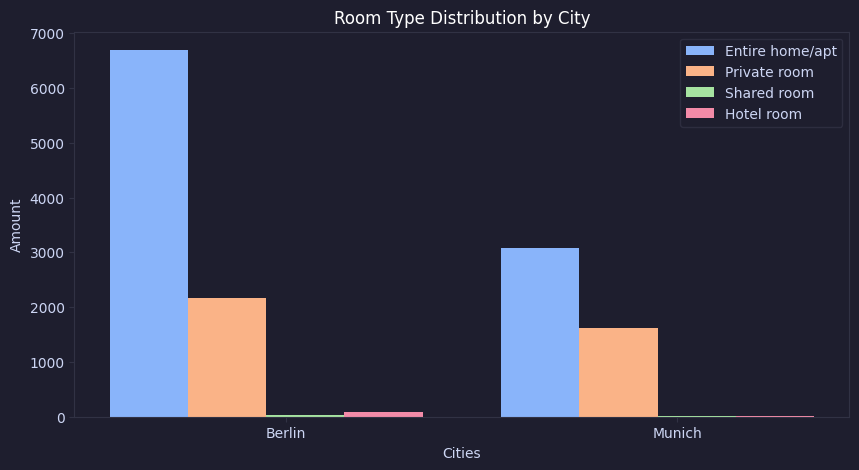

In [13]:
# Room Type Distribution

# Group data by city and room type and get the counts
room_type_counts = listings.groupby(['city', 'room_type'])['id'].count().reset_index().sort_values(by='id', ascending=False)

# Get the unique room types in the desired order
room_types = listings['room_type'].unique()

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Get the width of each bar
width = 0.2

# Calculate the positions of the bars
x_pos = range(len(room_type_counts['city'].unique())) #positions for cities on x-axis


# Create bars for each room type
for i, room_type in enumerate(room_types):
    # Get data for current room type
    room_data = room_type_counts[room_type_counts['room_type'] == room_type]

    # Plot the bar
    ax.bar([pos + i * width for pos in x_pos], room_data['id'], width, label=room_type)

# Set x-axis labels and ticks
ax.set_xticks([pos + width * (len(room_types) - 0.5) / 2 for pos in x_pos])  # Center the ticks
ax.set_xticklabels(room_type_counts['city'].unique())  # City names

# Set labels and title
ax.set_xlabel("Cities")
ax.set_ylabel("Amount")
ax.set_title("Room Type Distribution by City", color = 'white')

# Add a legend
ax.legend()

# Display the plot
plt.show()

### Prices per Room Type in each City

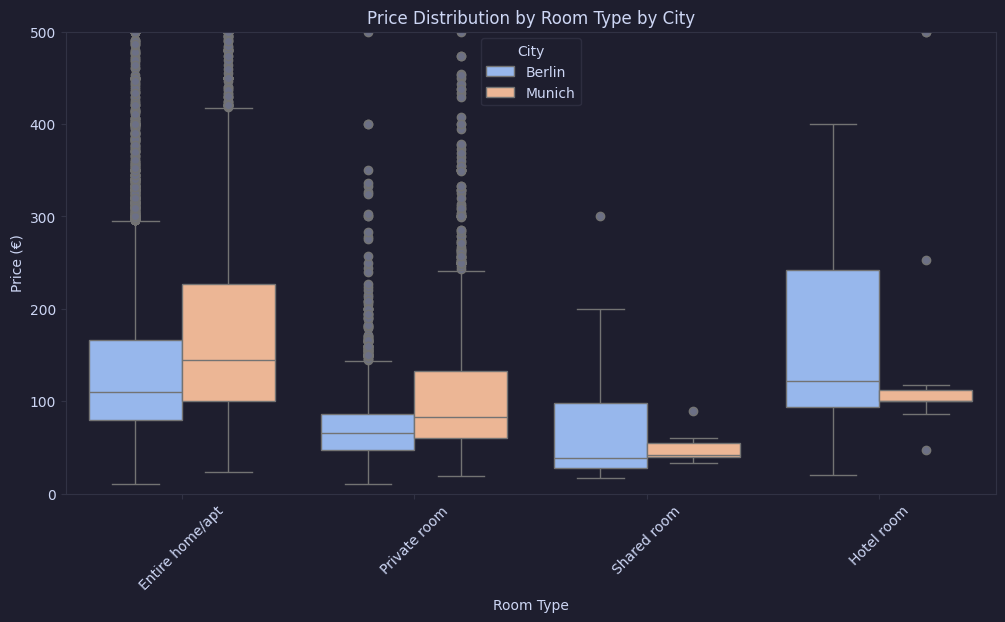

In [14]:
plt.figure(figsize=(12,6))

# Boxplot for price distribution by room type, separated by city
sns.boxplot(data=listings, x="room_type", y="price", hue="city")

plt.ylim(0, 500)  # Limit to focus on reasonable prices
plt.title("Price Distribution by Room Type by City")
plt.xlabel("Room Type")
plt.ylabel("Price (€)")
plt.legend(title="City")
plt.xticks(rotation=45)
plt.show()

### Distribution of Hosts with Multiple Listings in each City

<Figure size 800x800 with 0 Axes>

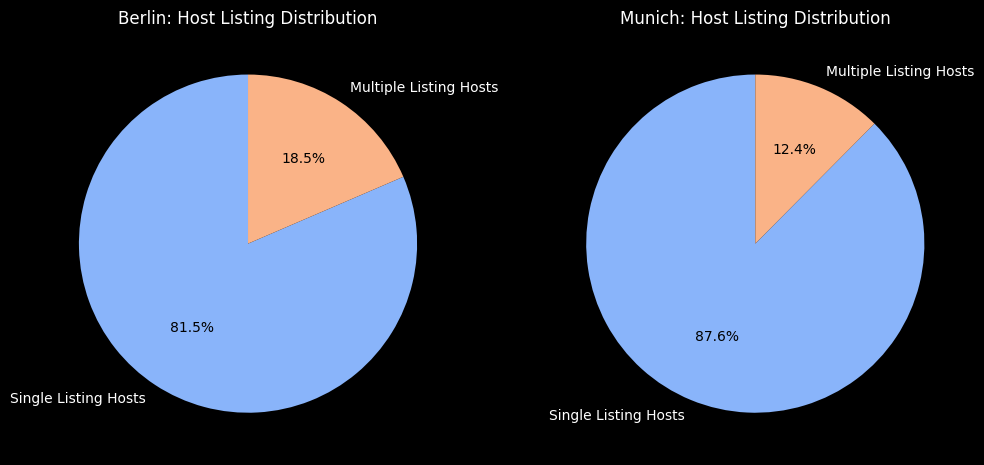

In [15]:
plt.figure(figsize=(8,8))

# Count number of listings per host in Berlin & Munich
listings_per_host = listings.groupby(["city", "host_id"]).size().reset_index(name="listings_count")

# Count hosts with 1 vs. multiple listings
berlin_single = (listings_per_host[listings_per_host["city"] == "Berlin"]["listings_count"] == 1).sum()
berlin_multi = (listings_per_host[listings_per_host["city"] == "Berlin"]["listings_count"] > 1).sum()
munich_single = (listings_per_host[listings_per_host["city"] == "Munich"]["listings_count"] == 1).sum()
munich_multi = (listings_per_host[listings_per_host["city"] == "Munich"]["listings_count"] > 1).sum()

# Data for pie chart
labels = ["Single Listing Hosts", "Multiple Listing Hosts"]
sizes_berlin = [berlin_single, berlin_multi]
sizes_munich = [munich_single, munich_multi]

# Define colors for both pies
#colors_berlin = ["lightblue", "peachpuff"]
#colors_munich = ["lightblue", "peachpuff"]

# Create figure with black background
fig, axes = plt.subplots(1, 2, figsize=(12,6), facecolor='black')

# Pie chart for Berlin
wedges_berlin, texts_berlin, autotexts_berlin = axes[0].pie(
    sizes_berlin, labels=labels, autopct="%1.1f%%",
    startangle=90, textprops={'color':'black'}
)

# Pie chart for Munich
wedges_munich, texts_munich, autotexts_munich = axes[1].pie(
    sizes_munich, labels=labels, autopct="%1.1f%%",
    startangle=90, textprops={'color':'black'}
)

# Set title colors to white
axes[0].set_title("Berlin: Host Listing Distribution", color="white")
axes[1].set_title("Munich: Host Listing Distribution", color="white")

# Ensure all outside labels are white
for text in texts_berlin + texts_munich:  # Merge both lists of labels
    text.set_color("white")

plt.show()


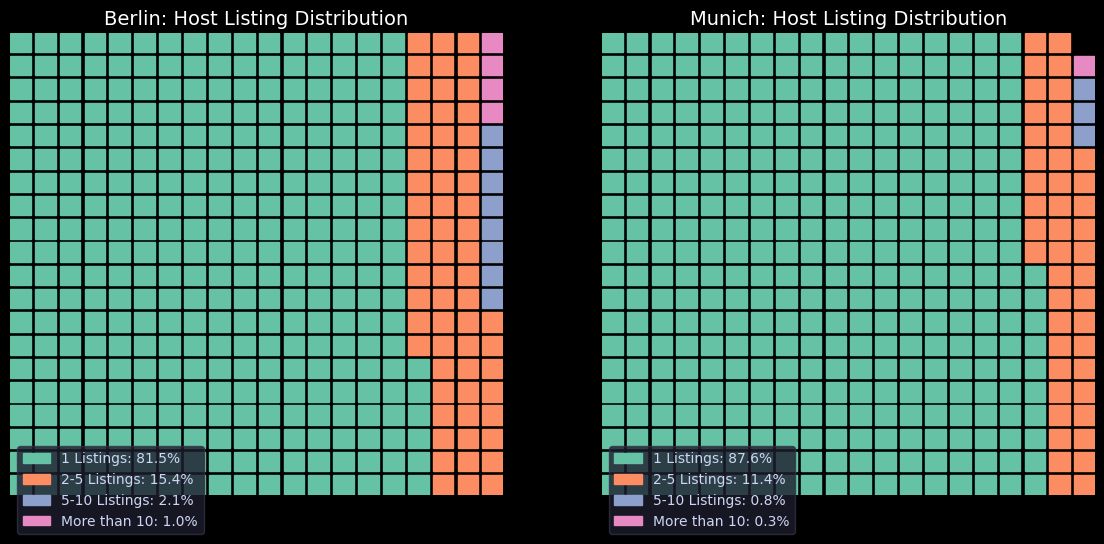

In [16]:
# Define categories for host listings
def categorize_hosts(count):
    if count == 1:
        return "1 Listings"
    elif 2 <= count <= 5:
        return "2-5 Listings"
    elif 5 <= count <= 10:
        return "5-10 Listings"
    else:
        return "More than 10"

# Apply categorization
listings_per_host["category"] = listings_per_host["listings_count"].apply(categorize_hosts)

# Count number of hosts in each category per city
category_counts = listings_per_host.groupby(["city", "category"]).size().unstack(fill_value=0)

# Convert to percentages
category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

# Define colors for categories
#category_colors = {
#    "2 Listings": "lightblue",
#    "3-5 Listings": "blue",
#    "6-10 Listings": "darkblue",
#    "More than 10": "black"
#}

# Create figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), facecolor="black")

# Berlin Waffle Plot
axes[0].set_title("Berlin: Host Listing Distribution", fontsize=14, color="white")
axes[0] = Waffle.make_waffle(
    rows=20,
    columns=20,
    values=category_percentages.loc["Berlin"].to_dict(),
    #colors=[category_colors[c] for c in category_percentages.columns],
    labels=[f"{c}: {category_percentages.loc['Berlin', c]:.1f}%" for c in category_percentages.columns],
    legend={"loc": "lower left", "bbox_to_anchor": (0, -0.1)},
    ax=axes[0]
)

# Munich Waffle Plot
axes[1].set_title("Munich: Host Listing Distribution", fontsize=14, color="white")
axes[1] = Waffle.make_waffle(
    rows=20,
    columns=20,
    values=category_percentages.loc["Munich"].to_dict(),
    #colors=[category_colors[c] for c in category_percentages.columns],
    labels=[f"{c}: {category_percentages.loc['Munich', c]:.1f}%" for c in category_percentages.columns],
    legend={"loc": "lower left", "bbox_to_anchor": (0, -0.1)},
    ax=axes[1]
)

plt.show()

### Average Price by Room Type per City

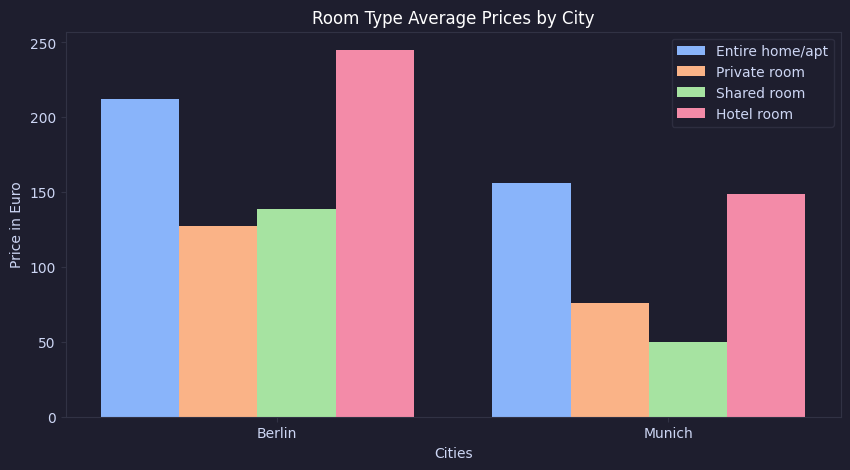

In [17]:
# Price per Room Type

# Group data by city and room type and get the average price
room_type_price = listings.groupby(['city', 'room_type'])['price'].mean().reset_index().sort_values(by='price', ascending=False)

# Get the unique room types in the desired order
room_types = listings['room_type'].unique()

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Get the width of each bar
width = 0.2

# Calculate the positions of the bars
x_pos = range(len(room_type_price['city'].unique())) #positions for cities on x-axis


# Create bars for each room type
for i, room_type in enumerate(room_types):
    # Get data for current room type
    room_data = room_type_price[room_type_price['room_type'] == room_type]

    # Plot the bar
    ax.bar([pos + i * width for pos in x_pos], room_data['price'], width, label=room_type)

# Set x-axis labels and ticks
ax.set_xticks([pos + width * (len(room_types) - 0.5) / 2 for pos in x_pos])  # Center the ticks
ax.set_xticklabels(room_type_price['city'].unique())  # City names

# Set labels and title
ax.set_xlabel("Cities")
ax.set_ylabel("Price in Euro")
ax.set_title("Room Type Average Prices by City", color = 'white')

# Add a legend
ax.legend()

# Display the plot
plt.show()

### Price Distribution per Room Type per Host Type

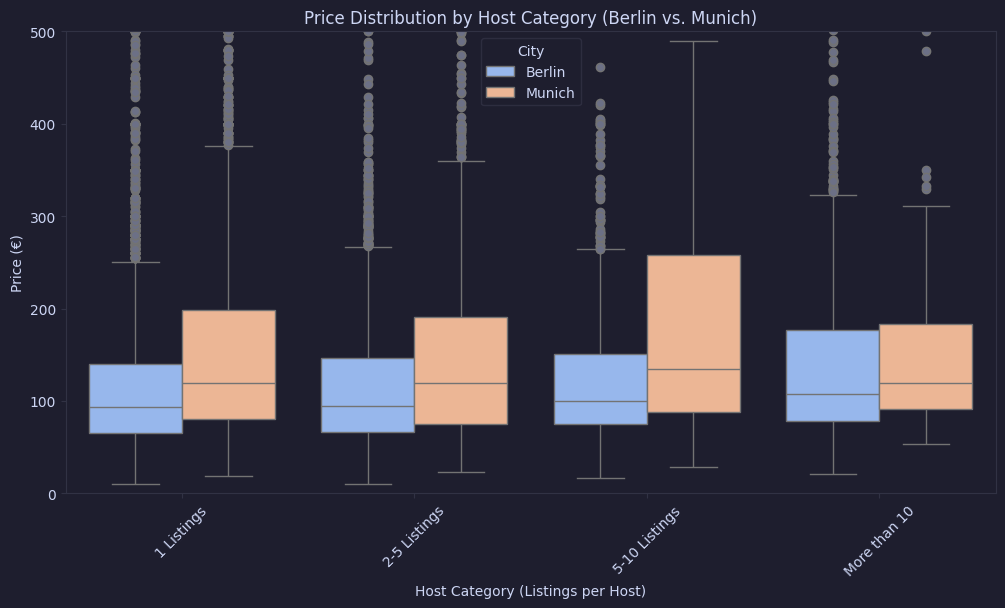

In [45]:
plt.figure(figsize=(12,6))
# Merge listings with listings_per_host on host_id
room_prices_host_type = listings.merge(listings_per_host, on=["host_id", "city"], how="left")

# Boxplot comparing price by host category, separated by city
sns.boxplot(
    data=room_prices_host_type,
    x="category", y="price",
    hue="city",
    #palette={"Berlin": "blue", "Munich": "orange"}
)

plt.ylim(0, 500)  # Limit to reasonable price range
plt.title("Price Distribution by Host Category (Berlin vs. Munich)")
plt.xlabel("Host Category (Listings per Host)")
plt.ylabel("Price (€)")
plt.xticks(rotation=45)
plt.legend(title="City")
plt.show()

### Impact of Multi-Listing on Prices per Neighbourhood

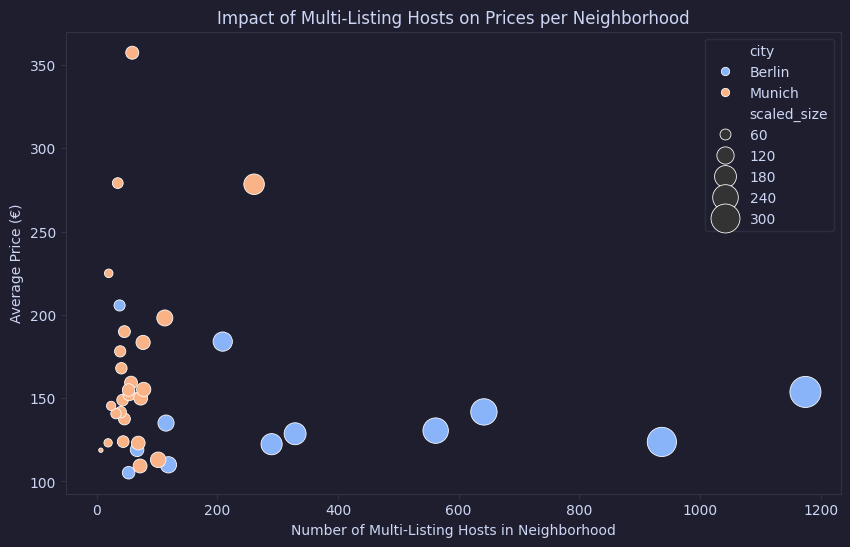

In [46]:
plt.figure(figsize=(10,6))

# Aggregate average price per neighborhood & number of multi-listing hosts
neighborhood_analysis = room_prices_host_type.groupby(["city","neighbourhood"]).agg(
    avg_price=("price", "mean"),
    multi_listings=("listings_count", lambda x: (x > 1).sum())  # Count multi-listing hosts
).reset_index()

# Apply transformation to enhance size difference
neighborhood_analysis["scaled_size"] = np.sqrt(neighborhood_analysis["multi_listings"]) * 10  # Square root for better scaling

# Scatter plot
sns.scatterplot(
    data=neighborhood_analysis,
    x="multi_listings", y="avg_price", hue="city", size="scaled_size",
    sizes=(10, 500)  # Manually adjust size range for better distinction,
)

plt.title("Impact of Multi-Listing Hosts on Prices per Neighborhood")
plt.xlabel("Number of Multi-Listing Hosts in Neighborhood")
plt.ylabel("Average Price (€)")
plt.show()

### Most Expensive Neighbourhoods in Berlin versus Munich

In [20]:
# Aggregate average price per neighborhood
neighbourhood_prices = room_prices_host_type.groupby(["city","neighbourhood"]).agg(
    avg_price=("price", "mean"),
).reset_index()

neighbourhood_prices_berlin = neighbourhood_prices[neighbourhood_prices["city"] == "Berlin"].sort_values(by="avg_price", ascending=False)
neighbourhood_prices_munich = neighbourhood_prices[neighbourhood_prices["city"] == "Munich"].sort_values(by="avg_price", ascending=False)

print("Top 10 Neighborhoods in Berlin by Average Price:")
print(neighbourhood_prices_berlin.head(10))
print("\nTop 10 Neighborhoods in Munich by Average Price:")
print(neighbourhood_prices_munich.head(10))

Top 10 Neighborhoods in Berlin by Average Price:
      city             neighbourhood   avg_price
3   Berlin     Marzahn - Hellersdorf  205.628866
11  Berlin        Treptow - Köpenick  183.946067
4   Berlin                     Mitte  153.718451
6   Berlin                    Pankow  141.730964
9   Berlin     Steglitz - Zehlendorf  135.039427
0   Berlin      Charlottenburg-Wilm.  130.508893
10  Berlin    Tempelhof - Schöneberg  128.638427
1   Berlin  Friedrichshain-Kreuzberg  123.721594
5   Berlin                  Neukölln  122.358466
7   Berlin             Reinickendorf  118.993548

Top 10 Neighborhoods in Munich by Average Price:
      city                 neighbourhood   avg_price
13  Munich                Altstadt-Lehel  357.300000
18  Munich        Feldmoching-Hasenbergl  279.052632
21  Munich  Ludwigsvorstadt-Isarvorstadt  278.365772
31  Munich              Schwanthalerhöhe  224.904110
22  Munich                   Maxvorstadt  198.120219
14  Munich                 Au-Haidhausen  18

### Effect of Host Gender or Commercial on Pricing per City

In [21]:
# Initialize gender detector
d = gender.Detector()

# load the World Gender-Name Dictionary
wgnd_path = "/content/drive/My Drive/AirBnB_BerlinvsMunich/wgnd/wgnd_2_0_name-gender-code.csv"
wgnd_data = pd.read_csv(wgnd_path)
# Extract name-gender mapping
name_gender_dict = dict(zip(wgnd_data["name"].str.lower(), wgnd_data["gender"].replace({"M": "Male", "F": "Female", "?": "Unknown"})))

In [22]:
# Define function for name classification
def classify_host(host_name):
    if pd.isna(host_name) or len(host_name) <= 2:
        return "Unknown"

    # Classify as "Couple" if it contains certain words
    couple_keywords = ["&", "+", "Familie", "And", "Und", "and", "und", "Fam.", "Mr and Mrs", "Mr & Mrs", "Husband and Wife"]
    if any(f in host_name for f in couple_keywords):
        return "Family"

    # Classify as "Commercial" if it contains business-related words
    commercial_keywords = [
        "Studio", "Project", "Suites", "Hostel", "Renting", "Hotel", "Apartments", "Team", "Residence",
        "Management", "Group", "Company", "Corporate", "Real Estate", "Investment", "Flats", "flats",
        "Aparthotel", "City", "Xperior"
    ]
    if any(s in host_name for s in commercial_keywords):
        return "Commercial"

    # Clean the name
    host_name = re.sub(r"\.", "", host_name)  # Remove dots (e.g., "Marc." → "Marc")
    host_name = re.sub(r"^[A-Z]\.?(\s+|)([A-Z][a-z]+)", r"\2", host_name)  # Remove initials like "H.Christian"

    # Replace hyphen with space and split names
    first_names = host_name.replace("-", " ").split()

    # Select the first valid name (must be more than 1 letter)
    first_name = next((name for name in first_names if len(name) > 1), None)
    if not first_name:
        return "Unknown"

    # Try WGND dictionary first
    first_name_lower = first_name.lower()
    if first_name_lower in name_gender_dict:
        return name_gender_dict[first_name_lower]

    # Fallback to gender-guesser
    gender_result = d.get_gender(first_name_lower)
    if gender_result in ["male", "mostly_male"]:
        return "Male"
    elif gender_result in ["female", "mostly_female"]:
        return "Female"
    else:
        return "Unknown"  # If no match found

# Apply function to dataset
room_prices_host_type["host_type"] = room_prices_host_type["host_name"].apply(classify_host)

# Display results
print(room_prices_host_type["host_type"].value_counts())

# Show unknown names for manual review
print(room_prices_host_type[room_prices_host_type["host_type"] == "Unknown"][["host_name", "host_type"]].head(10))

host_type
Male          6830
Female        4473
Family        1013
Unknown        858
Commercial     542
Name: count, dtype: int64
       host_name host_type
7         Ramfis   Unknown
18         Guidi   Unknown
36            Ju   Unknown
43          Alke   Unknown
77            Au   Unknown
240       Joasha   Unknown
241     Meimouna   Unknown
268  Gerit Bella   Unknown
282           Na   Unknown
291           V.   Unknown


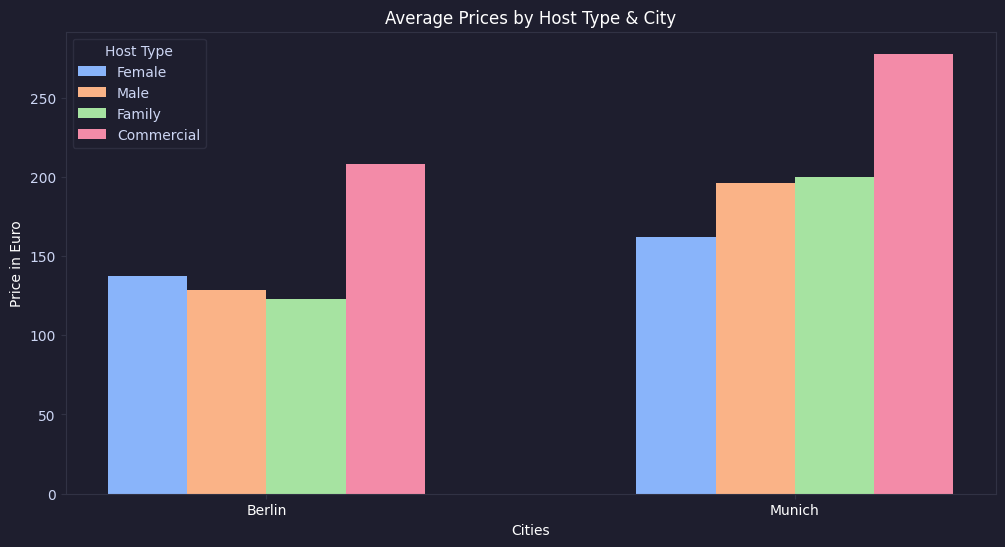

In [53]:
# drop unknown host types
prices_host_type = room_prices_host_type[room_prices_host_type['host_type'] != "Unknown"]

# Get the unique host types in the desired order
host_types = prices_host_type['host_type'].unique()
cities = prices_host_type['city'].unique()

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Set width of each bar
width = 0.15
x_pos = np.arange(len(cities))  # Position of each city

# Plot bars for each host type
for i, host_type in enumerate(host_types):
    # Get data for the current host type
    host_data = prices_host_type[prices_host_type['host_type'] == host_type].groupby("city")["price"].mean()

    # Plot bars
    ax.bar(x_pos + i * width, host_data, width, label=host_type)

# Set x-axis labels
ax.set_xticks(x_pos + width * (len(host_types) - 1) / 2)  # Center x-axis labels
ax.set_xticklabels(cities, color="white")

# Set labels and title
ax.set_xlabel("Cities", color="white")
ax.set_ylabel("Price in Euro", color="white")
ax.set_title("Average Prices by Host Type & City", color="white")

# Improve legend
ax.legend(title="Host Type")

# Display the plot
plt.show()


### Differences in language and price in Berlin and Munich

In [24]:
# Define lists of common German & English words found in listing names
german_keywords = {"wohnung", "berliner", "platz", "straße", "zentrale", "nähe", "ruhig",
                   "sonnig", "terrasse", "altbau", "domizil", "schöne", "zimmer", "hbf", "bahnhof", "hauptstadt",
                   "zentral", "oase", "geräumig", "und", "gemütlich", "berg", "herzen", "herz", "mitten"}

english_keywords = {"apartment", "flat", "loft", "room", "suite", "bedroom", "studio", "city",
                    "view", "modern", "central", "quiet", "design", "spacious", "luxury", "terrace",
                    "park", "garden", "bathroom", "penthouse", "downtown", "beautiful", "weekend", "for",
                    "near", "bath", "townhouse", "holiday", "rental", "borough", "place", "home", "building",
                    "renovated", "location", "night", "furnished", "mountain", "retreat"}

# Function to classify as English or German based on keywords
def classify_by_keywords(name):
    if pd.isna(name) or len(name) < 3:
        return "unknown"

    name_clean = re.sub(r'[^\w\s-]', '', name).strip().lower()  # Remove special characters, lowercase

    # Check for German keywords
    if any(word in name_clean for word in german_keywords):
        return "de"

    # Check for English keywords
    if any(word in name_clean for word in english_keywords):
        return "en"

    return "unknown"

# Apply keyword-based classification
listings["language"] = listings["name"].apply(classify_by_keywords)

# Check classification before running detection
print(listings["language"].value_counts())
listings[["name", "language"]].head(20)

print(listings[listings["language"] == "unknown"][["name", "language"]].head(10))

language
en         6765
de         5524
unknown    1427
Name: count, dtype: int64
                                                  name language
96   Dach-Apartement "Blueberry Hill"  in Berlin-Mitte  unknown
161                   BEMYGUEST-FAMILY RESIDENCY MITTE  unknown
189                    100 qm in Berlin Mitte - center  unknown
211             70qm 1br - bright, artsy and high tech  unknown
212                 Gästeappartement in Rudow (App. 2)  unknown
216                  Gästeappartement in Rudow (App.1)  unknown
256            Truly Neukoelln (Minimum stay 3 months)  unknown
270     Over the roofs of Berlin with Lift and Netflix  unknown
278                                          3 für 2-3  unknown
285                Above the roofs of Berlin Neukölln!  unknown


In [25]:
# Function to detect language only for "unknown" cases
def detect_language(name):
    if name == "unknown":
        try:
            lang, confidence = langid.classify(name)
            return lang if confidence > 0.8 else "unknown"
        except:
            return "unknown"
    return name  # Keep previously classified results

# Apply detection only to "unknown" names
listings["language"] = listings["language"].apply(detect_language)

# Final check of classification
print(listings["language"].value_counts())
listings[["name", "language"]].head(20)

print(listings[listings["language"] == "de"][["name", "language"]].head(10))

###NOTE: Names classified as english may also contain cases of "denlish", a mix of german and english

language
en    8192
de    5524
Name: count, dtype: int64
                                                 name language
2                 Studio Apartment in Prenzlauer Berg       de
3                  In the Heart of Berlin - Kreuzberg       de
4       Beautiful Kreuzberg studio - 3 months minimum       de
6                    Studio in the Heart of Kreuzberg       de
8                       "Prenzel Garten" mit Terrasse       de
10                Helmholtzplatz Bright&Spacious Apt.       de
11             Beautiful apartment in Prenzlauer Berg       de
12                  Quiet 2 rooms next Helmholtzplatz       de
13  PEACEFUL FLAT WITH VINTAGE TOUCH IN PRENZLAUER...       de
14                   Ku'damm-Nähe,sonnig,ruhig,Balkon       de


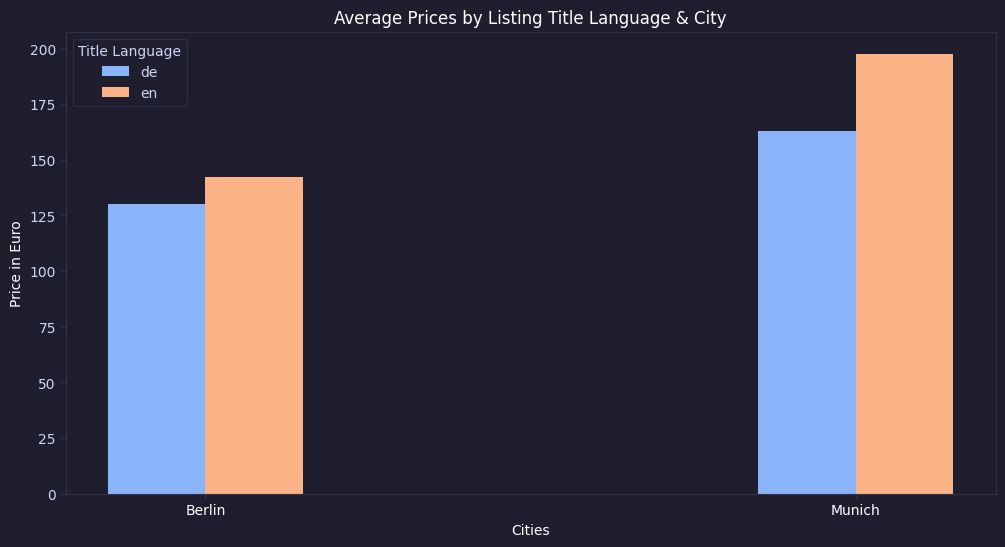

In [56]:
# Group data by city and room type and get the average price
language_price = listings.groupby(['city', 'language'])['price'].mean().reset_index().sort_values(by='price', ascending=True)

# Get the unique languages
languages = language_price['language'].unique()
cities = language_price['city'].unique()

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Set width of each bar
width = 0.15
x_pos = np.arange(len(cities))  # Position of each city

# Plot bars for each host type
for i, language in enumerate(languages):
    # Get data for the current host type
    language_data = language_price[language_price['language'] == language].groupby("city")["price"].mean()

    # Plot bars
    ax.bar(x_pos + i * width, language_data, width, label=language)

# Set x-axis labels
ax.set_xticks(x_pos + width * (len(languages) - 1) / 2)  # Center x-axis labels
ax.set_xticklabels(cities, color="white")

# Set labels and title
ax.set_xlabel("Cities", color="white")
ax.set_ylabel("Price in Euro", color="white")
ax.set_title("Average Prices by Listing Title Language & City", color="white")

# Improve legend
ax.legend(title="Title Language")

# Display the plot
plt.show()

### Differences in listing semantic between Cities  

In [27]:
translator = GoogleTranslator(source='de', target='en')

# Filter only German names
german_names = listings[listings["language"] == "de"]["name"]

# Function to translate a batch of names
def batch_translate(names):
    translated = []
    for name in names:
        try:
            translated.append(translator.translate(name))
            time.sleep(0.5)  # Avoid hitting API limits
        except:
            translated.append(name)  # Keep original if translation fails
    return translated

# Apply batch translation
batch_size = 10  # Adjust based on API limits
translated_names = []

# Uncomment to activate this line - translation takes time
#for i in range(0, len(german_names), batch_size):
#    batch = german_names.iloc[i : i + batch_size]
#    translated_names.extend(batch_translate(batch))

# Assign translated names back to DataFrame
#listings.loc[listings["language"] == "de", "translated_name"] = translated_names

# read in saved csv with translated listing names
listings_path = "/content/drive/My Drive/AirBnB_BerlinvsMunich/translated_airbnb_listings.csv"
listings = pd.read_csv(listings_path)

# Assign translated names for listings that where already in english
listings.loc[listings["language"] == "en", "translated_name"] = listings["name"]

# Check results
print(listings[["name", "translated_name", "language"]].info())
listings[["name", "translated_name", "language"]].head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13716 entries, 0 to 13715
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             13716 non-null  object
 1   translated_name  13716 non-null  object
 2   language         13716 non-null  object
dtypes: object(3)
memory usage: 321.6+ KB
None


name  \
0                     Fabulous Flat in great Location   
1                 Geourgeous flat - outstanding views   
2                 Studio Apartment in Prenzlauer Berg   
3                  In the Heart of Berlin - Kreuzberg   
4       Beautiful Kreuzberg studio - 3 months minimum   
5                       Designer Loft in Berlin Mitte   
6                    Studio in the Heart of Kreuzberg   
7                       "Prenzel Garten" mit Terrasse   
8                    Apartment in the heart of Berlin   
9                 Helmholtzplatz Bright&Spacious Apt.   
10             Beautiful apartment in Prenzlauer Berg   
11                  Quiet 2 rooms next Helmholtzplatz   
12  PEACEFUL FLAT WITH VINTAGE TOUCH IN PRENZLAUER...   
13                   Ku'damm-Nähe,sonnig,ruhig,Balkon   
14                Weekend in Berlin Party Center - II   
15                       The Berlin Artist Apartment.   
16                                 Hauptstadt-Domizil   
17                  light quiet beautiful 4 room flat   
18                Super Apartment in Berlin/Kreuzberg   
19  Rooftop apt w/ a view, 2 bedrooms/bathrooms, s...   

                                      translated_name language  
0                     Fabulous Flat in great Location       en  
1                 Geourgeous flat - outstanding views       en  
2                 Studio apartment in Prenzlauer Berg       de  
3                  In The Heart of Berlin - Kreuzberg       de  
4       Beautiful Kreuzberg Studio - 3 Months minimum       de  
5                       Designer Loft in Berlin Mitte       en  
6                    Studio in the Heart of Kreuzberg       de  
7                       "Prenzel Garden" with terrace       de  
8                    Apartment in the heart of Berlin       en  
9               Helmholtzplatz Bright & Spacious Apt.       de  
10             Beautiful apartment in Prenzlauer Berg       de  
11                  Quiet 2 Rooms Next Helmholtzplatz       de  
12  Peaceful flat with vintage touch in Prenzlauer...       de  
13                Ku'damm close, sunny, calm, balcony       de  
14                Weekend in Berlin Party Center - II       en  
15                       The Berlin Artist Apartment.       en  
16                                   Capital-domicile       de  
17                  light quiet beautiful 4 room flat       en  
18                Super apartment in Berlin/Kreuzberg       de  
19  Rooftop apt w/ a view, 2 bedrooms/bathrooms, s...       en

In [28]:
# Save translated listings to CSV to avoid rerunning translations
#listings.to_csv("translated_airbnb_listings.csv", index=False)

#print("Saved to translated_airbnb_listings.csv ✅")

In [29]:
# Define stopwords list
stopwords = {
    "in", "the", "with", "of", "and", "to", "a", "near", "on", "at", "for", "by", "from", "is",
    "with", "your", "our", "this", "that", "an", "or", "as", "be", "it", "you", "we", "has",
    "its", "not", "are", "if", "but", "also", "so", "all", "one", "about", "more", "some",
    "only", "just", "which", "what", "where", "who", "when", "how", "there", "very", "much",
    "many", "too", "can", "i", "he", "she", "they", "them", "was", "been", "do", "does",
    "my", "me", "him", "her", "their", "us", "would", "could", "should", "than", "then", "because",
    "within", "outside", "inside", "before", "after", "during", "against", "among", "between",
    "under", "over", "without", "into", "onto", "beside", "upon", "amongst", "out", "up",
    "down", "again", "back", "each", "few", "several", "most", "other", "same", "own",
    "i'm", "you're", "he's", "she's", "we're", "they're", "it's", "did", "didn't", "doesn't",
    "haven't", "hasn't", "hadn't", "weren't", "wasn't", "shouldn't", "couldn't", "wouldn't",
    "don't", "doesn't", "isn't", "won't", "can't", "ain't", "such", "by", "nr", "no", "i", "your",
    "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "15", "1", "0",
    "qm", "sqm", "w", "numa", "für", "zi", "min", "minutes", "side", "subway", "station", "der",
    "lage"
}

# Function to clean and extract words, removing stopwords
def extract_words(text):
    if pd.isna(text):
        return []
    words = re.findall(r'\b\w+\b', str(text).lower())  # Extract words and make lowercase
    return [word for word in words if word not in stopwords]  # Remove stopwords

# Create an empty dictionary to store word counts for each city
city_word_counts = {}

# Iterate over each city and calculate word frequencies
for city, names in listings.groupby("city")["translated_name"]:
    word_list = [word for name in names.dropna() for word in extract_words(name)]
    city_word_counts[city] = Counter(word_list)  # Store word counts for each city separately

# Convert to DataFrame for easier visualization
word_counts_df = pd.DataFrame(city_word_counts).fillna(0).astype(int)  # Fill missing values with 0

# Display the top 20 most common words per city
for city in word_counts_df.columns:
    print(f"\n🔹 **Top 20 Words in {city} Listings (After Stopword Removal):**")
    print(word_counts_df[city].sort_values(ascending=False).head(20))


🔹 **Top 20 Words in Berlin Listings (After Stopword Removal):**
apartment     2945
berlin        1962
room          1935
cozy           701
central        633
studio         624
flat           576
kreuzberg      515
mitte          493
city           469
balcony        415
quiet          378
beautiful      378
loft           370
bright         369
berg           343
center         334
heart          321
prenzlauer     314
modern         295
Name: Berlin, dtype: int64

🔹 **Top 20 Words in Munich Listings (After Stopword Removal):**
apartment      1855
room           1464
munich          900
cozy            498
central         467
city            362
center          359
oktoberfest     273
studio          269
nice            250
quiet           243
flat            221
location        195
beautiful       186
modern          185
balcony         180
schwabing       173
private         159
heart           154
bright          152
Name: Munich, dtype: int64


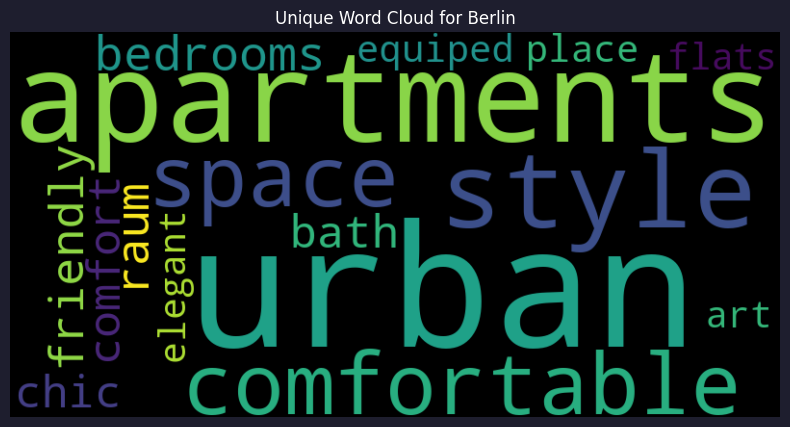

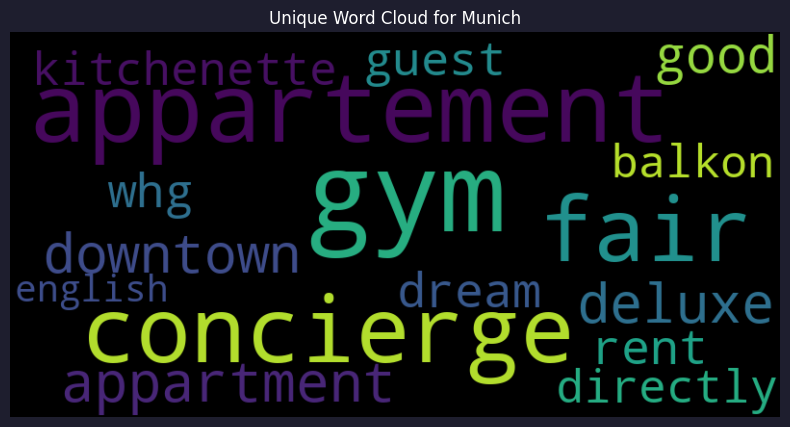

In [30]:
# List of boroughs and sights in Berlin & Munich (not case-sensitive)
berlin_boroughs = {"mitte", "kreuzberg", "charlottenburg", "friedrichshain", "neukölln",
                   "spandau", "lichtenberg", "treptow", "köpenick", "marzahn", "hellersdorf",
                   "pankow", "tempelhof", "schöneberg", "wedding", "reinickendorf",
                   "prenzlauer", "berg", "ku", "damm", "middle", "platz", "mauerpark",
                   "berlin", "west", "kudamm", "kurfürstendamm", "prenzlauerberg", "alexanderplatz",
                   "alex", "spree", "blueground", "canal"}
munich_boroughs = {"maxvorstadt", "schwabing", "neuhausen", "sendling", "trudering",
                   "riem", "berg", "perlach", "bogenhausen", "westend", "haidhaußen",
                   "ramersdorf", "hasenbergl", "moosach", "lauben", "obermenzing", "forstenried",
                   "olympiapark", "haidhausen", "oktoberfest", "isar", "munich", "münchen",
                   "theresienwiese", "nymphenburg", "marienplatz", "messe", "pasing", "bmw", "giesing"}

# Combine borough names and stopwords for filtering
all_exclusions = berlin_boroughs | munich_boroughs | stopwords

# Function to clean and extract words while filtering out borough names
def extract_words(text):
    if pd.isna(text):
        return []
    words = re.findall(r'\b\w+\b', str(text).lower())  # Extract words and lowercase
    return [word for word in words if word not in all_exclusions]  # Exclude borough names

# Create an empty dictionary to store word counts per city
city_word_counts = {}

# Iterate over each city and calculate word frequencies
for city, names in listings.groupby("city")["translated_name"]:
    word_list = [word for name in names.dropna() for word in extract_words(name)]
    city_word_counts[city] = Counter(word_list)  # Store word counts for each city separately

# Convert to DataFrame
word_counts_df = pd.DataFrame(city_word_counts).fillna(0).astype(int)

# Get top 100 words per city
top_100_berlin = set(word_counts_df["Berlin"].sort_values(ascending=False).head(100).index)
top_100_munich = set(word_counts_df["Munich"].sort_values(ascending=False).head(100).index)

# Find truly unique words (words in one city's top 100 but not the other)
unique_berlin_words = top_100_berlin - top_100_munich
unique_munich_words = top_100_munich - top_100_berlin

# Create dictionaries of word frequencies for unique words
berlin_unique_word_counts = {word: word_counts_df.loc[word, "Berlin"] for word in unique_berlin_words}
munich_unique_word_counts = {word: word_counts_df.loc[word, "Munich"] for word in unique_munich_words}

# Function to generate a word cloud
def generate_wordcloud(city, word_counts):
    wordcloud = WordCloud(
        width=800, height=400,
        #background_color="black",
        #colormap="coolwarm"
    ).generate_from_frequencies(word_counts)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Unique Word Cloud for {city}", color="white")
    plt.show()

# Generate word clouds for unique words in each city
generate_wordcloud("Berlin", berlin_unique_word_counts)
generate_wordcloud("Munich", munich_unique_word_counts)

# Bookings

## Data Cleaning

In [31]:
# merging listings dataframes
# Add a column to distinguish between cities
berlin_calendar["city"] = "Berlin"
munich_calendar["city"] = "Munich"

# Concatenate both datasets into one
calendar = pd.concat([berlin_calendar, munich_calendar], ignore_index=True)

# Display shape & first few rows
print("Merged Data Shape:", calendar.shape)
calendar.head(10)

Merged Data Shape: (7760349, 8)


listing_id        date available   price  adjusted_price  minimum_nights  \
0       97945  2024-12-27         f  $95.00             NaN               2   
1       97945  2024-12-28         f  $95.00             NaN               2   
2       97945  2024-12-29         f  $95.00             NaN               2   
3       97945  2024-12-30         t  $95.00             NaN               2   
4       97945  2024-12-31         t  $95.00             NaN               2   
5       97945  2025-01-01         f  $95.00             NaN               2   
6       97945  2025-01-02         f  $95.00             NaN               2   
7       97945  2025-01-03         f  $95.00             NaN               2   
8       97945  2025-01-04         f  $95.00             NaN               2   
9       97945  2025-01-05         f  $95.00             NaN               2   

   maximum_nights    city  
0              90  Berlin  
1              90  Berlin  
2              90  Berlin  
3              90  Berlin  
4              90  Berlin  
5              90  Berlin  
6              90  Berlin  
7              90  Berlin  
8              90  Berlin  
9              90  Berlin

In [32]:
# info
print(calendar.info())
# Check missing values
print("Missing values in listings dataset:")
print(calendar.isnull().sum(), berlin_calendar.isnull().sum() + munich_calendar.isnull().sum())

# remove adjusted_price as this is always missing
calendar.drop(columns=["adjusted_price"], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7760349 entries, 0 to 7760348
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  float64
 5   minimum_nights  int64  
 6   maximum_nights  int64  
 7   city            object 
dtypes: float64(1), int64(3), object(4)
memory usage: 473.7+ MB
None
Missing values in listings dataset:
listing_id              0
date                    0
available               0
price                   0
adjusted_price    7760349
minimum_nights          0
maximum_nights          0
city                    0
dtype: int64 listing_id              0
date                    0
available               0
price                   0
adjusted_price    7760349
minimum_nights          0
maximum_nights          0
city                    0
dtype: int64


In [33]:
# replace availability labels for better readability
calendar["available"] = calendar["available"].replace({"t": "True", "f": "False"})

# change date to date format
calendar["date"] = pd.to_datetime(calendar["date"])

# change price to float
calendar["price"] = pd.to_numeric(calendar["price"].str.replace("$", ""), errors="coerce")

calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7760349 entries, 0 to 7760348
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4   minimum_nights  int64         
 5   maximum_nights  int64         
 6   city            object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 414.4+ MB


## Exploratory Data Analysis

### Price Variablity per City

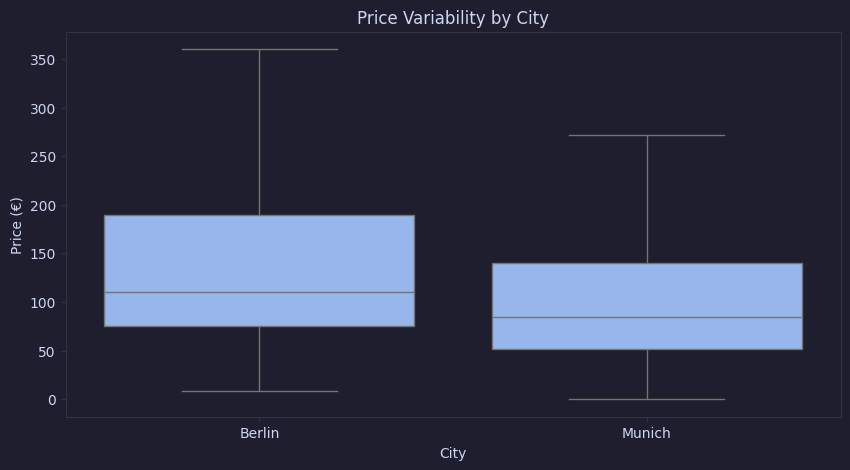

In [34]:
plt.figure(figsize=(10, 5))

sns.boxplot(data=calendar, x="city", y="price", showfliers=False)  # Remove outliers for readability
plt.title("Price Variability by City")
plt.xlabel("City")
plt.ylabel("Price (€)")
plt.show()

### Seasonal Price Trends

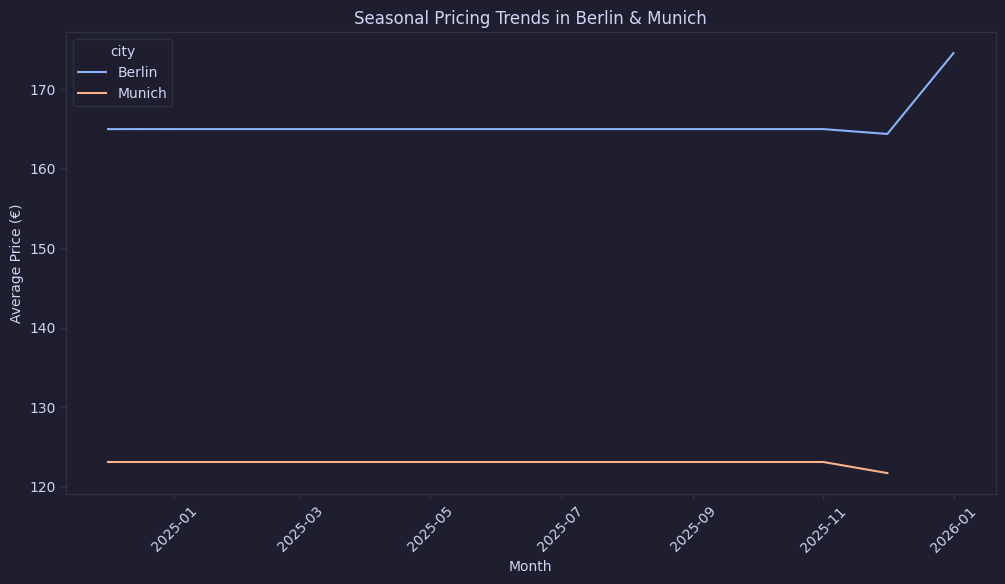

In [35]:
plt.figure(figsize=(12,6))

# Group by month
monthly_trends = calendar.groupby([calendar["date"].dt.to_period("M"), "city"])["price"].mean().reset_index()

# Convert 'date' column to timestamp for plotting
monthly_trends["date"] = monthly_trends["date"].dt.to_timestamp()  # Convert Period to Timestamp

# Plot price trends
sns.lineplot(data=monthly_trends, x="date", y="price", hue="city")
plt.title("Seasonal Pricing Trends in Berlin & Munich")
plt.xlabel("Month")
plt.ylabel("Average Price (€)")
plt.xticks(rotation=45)
plt.show()

### Differences in Minimum Night Stay

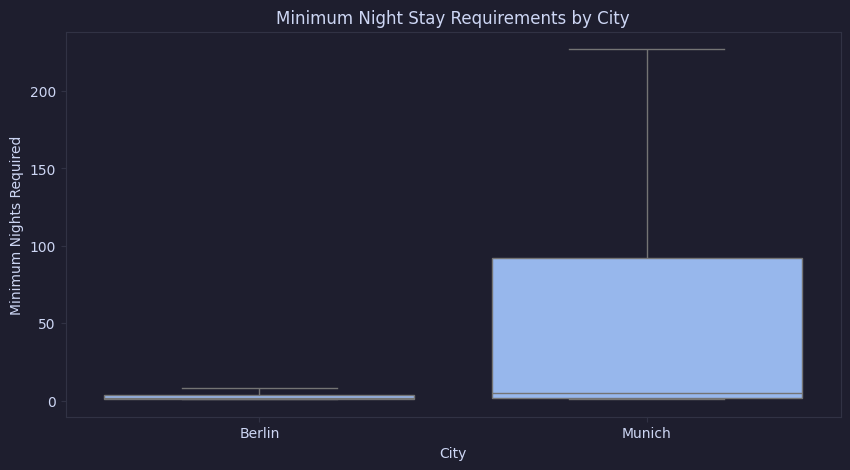

In [36]:
plt.figure(figsize=(10, 5))

sns.boxplot(data=calendar, x="city", y="minimum_nights", showfliers=False)  # Hide outliers for clarity
plt.title("Minimum Night Stay Requirements by City")
plt.xlabel("City")
plt.ylabel("Minimum Nights Required")
#plt.ylim(0, 50)  # Focus on reasonable limits
plt.show()

### Availability Trends over the Year by City

In [57]:
plt.figure(figsize=(12, 5))

# Group data by month and city
calendar["month"] = calendar["date"].dt.to_period("M")
availability_per_month = calendar.groupby(["month", "city"])["available"].apply(lambda x: (x == "True").mean()).reset_index()

# Convert 'date' column to timestamp for plotting
availability_per_month["month"] = availability_per_month["month"].dt.to_timestamp()  # Convert Period to Timestamp

# Plot availability trends
sns.lineplot(data=availability_per_month, x="month", y="available", hue="city")
plt.title("Availability Trends Over Time by City")
plt.xlabel("Month")
plt.ylabel("Availability Rate")
plt.xticks(rotation=45)
plt.show()

month    city  available
0  2024-12-01  Berlin   0.247067
1  2024-12-01  Munich   0.268229
2  2025-01-01  Berlin   0.406806
3  2025-01-01  Munich   0.425034
4  2025-02-01  Berlin   0.458856
5  2025-02-01  Munich   0.451628
6  2025-03-01  Berlin   0.461138
7  2025-03-01  Munich   0.452021
8  2025-04-01  Berlin   0.336140
9  2025-04-01  Munich   0.405742
10 2025-05-01  Berlin   0.358946
11 2025-05-01  Munich   0.412769
12 2025-06-01  Berlin   0.366506
13 2025-06-01  Munich   0.397852
14 2025-07-01  Berlin   0.313356
15 2025-07-01  Munich   0.366735
16 2025-08-01  Berlin   0.323267
17 2025-08-01  Munich   0.382838
18 2025-09-01  Berlin   0.281669
19 2025-09-01  Munich   0.345175
20 2025-10-01  Berlin   0.233657
21 2025-10-01  Munich   0.321614
22 2025-11-01  Berlin   0.242494
23 2025-11-01  Munich   0.322736
24 2025-12-01  Berlin   0.240200
25 2025-12-01  Munich   0.317125
26 2026-01-01  Berlin   0.250000

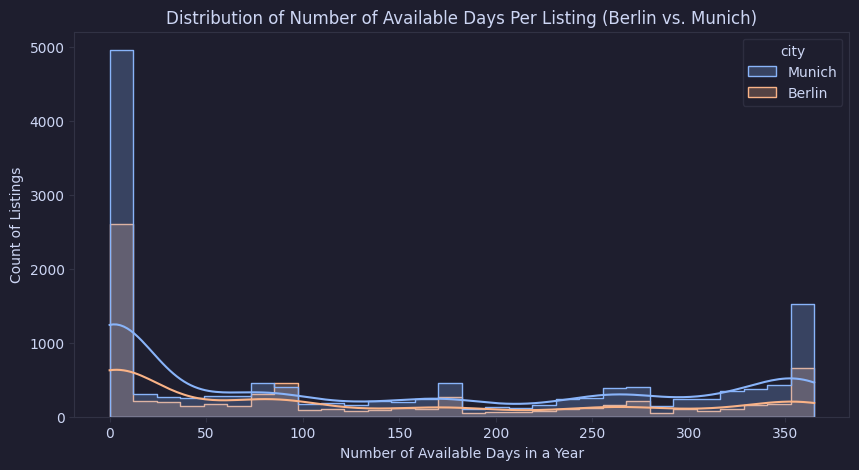

In [38]:
plt.figure(figsize=(10, 5))

# Count availability per listing
availability_days = calendar.groupby(["listing_id","city"])["available"].apply(lambda x: (x == "True").sum()).reset_index(name="available") #reset_index to convert to DataFrame

sns.histplot(data=availability_days, x="available", hue="city", bins=30, kde=True, element="step") # element="step" prevents bar overlap
plt.title("Distribution of Number of Available Days Per Listing (Berlin vs. Munich)")
plt.xlabel("Number of Available Days in a Year")
plt.ylabel("Count of Listings")
plt.show()

# Geographical Visualization of Key Features and Trends

## Data Preparation

In [139]:
# Load GeoJSON files for Berlin and Munich
geojson_b_path = "/content/drive/My Drive/AirBnB_BerlinvsMunich/Berlin/neighbourhoods_b.geojson"
geojson_m_path = "/content/drive/My Drive/AirBnB_BerlinvsMunich/Munich/neighbourhoods_m.geojson"

neighbourhoods_b = gpd.read_file(geojson_b_path)
neighbourhoods_m = gpd.read_file(geojson_m_path)

# Fix Berlin data (rename neighbourhood_group)
neighbourhoods_b.drop(columns=["neighbourhood"], errors="ignore", inplace=True)
neighbourhoods_b.rename(columns={"neighbourhood_group": "neighbourhood"}, inplace=True)

# Load Airbnb price data
neigh_price = listings.groupby("neighbourhood")["price"].mean().reset_index()
listings = listings.merge(prices_host_type, how="left")  # Add host type info

# Aggregate data for visualization
neigh_data = listings.groupby(["neighbourhood", "language", "room_type", "host_type"]).agg(
    avg_price=("price", "mean"),
    total_listings=("id", "count")
).reset_index()

# Normalize proportions per category
def normalize_proportions(df, category):
    pivot = df.pivot_table(index="neighbourhood", columns=category, values="total_listings", aggfunc="sum", fill_value=0)
    pivot["total"] = pivot.sum(axis=1)
    for col in pivot.columns:
        if col != "total":
            pivot[col] = pivot[col] / pivot["total"]
    return pivot.drop(columns=["total"]).reset_index()

# Get proportions
neigh_pivot = normalize_proportions(neigh_data, "language")
room_pivot = normalize_proportions(neigh_data, "room_type")
host_pivot = normalize_proportions(neigh_data, "host_type")

# Merge all datasets into Berlin & Munich GeoJSONs
geo_b = neighbourhoods_b.merge(neigh_price, on="neighbourhood", how="left").merge(neigh_pivot, on="neighbourhood", how="left").merge(room_pivot, on="neighbourhood", how="left").merge(host_pivot, on="neighbourhood", how="left").fillna(0)
geo_m = neighbourhoods_m.merge(neigh_price, on="neighbourhood", how="left").merge(neigh_pivot, on="neighbourhood", how="left").merge(room_pivot, on="neighbourhood", how="left").merge(host_pivot, on="neighbourhood", how="left").fillna(0)

# Convert DataFrame to GeoJSON
def convert_to_geojson(gdf):
    geojson_data = {
        "type": "FeatureCollection",
        "features": []
    }
    for _, row in gdf.iterrows():
        feature = {
            "type": "Feature",
            "properties": {
                "neighbourhood": row["neighbourhood"],
                "price": round(row["price"], 2),
                "german_listings": round(row["de"] * 100, 1),
                "english_listings": round(row["en"] * 100, 1),
                "Entire_home": round(row["Entire home/apt"] * 100, 1),
                "Hotel_room": round(row["Hotel room"] * 100, 1),
                "Private_room": round(row["Private room"] * 100, 1),
                "Shared_room": round(row["Shared room"] * 100, 1),
                "Commercial_Host": round(row["Commercial"] * 100, 1),
                "Family_Host": round(row["Family"] * 100, 1),
                "Female_Host": round(row["Female"] * 100, 1),
                "Male_Host": round(row["Male"] * 100, 1),
            },
            "geometry": row["geometry"].__geo_interface__
        }
        geojson_data["features"].append(feature)
    return json.dumps(geojson_data)

geojson_b = convert_to_geojson(geo_b)
geojson_m = convert_to_geojson(geo_m)

<ipython-input-139-90394d75d9ec>:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  geo_m = neighbourhoods_m.merge(neigh_price, on="neighbourhood", how="left").merge(neigh_pivot, on="neighbourhood", how="left").merge(room_pivot, on="neighbourhood", how="left").merge(host_pivot, on="neighbourhood", how="left").fillna(0)


## Folium Maps for Interesting Features and Information Pop-Ups

In [202]:
# Create maps for Berlin & Munich
m_berlin = folium.Map(location=[52.52, 13.40], zoom_start=11)
m_munich = folium.Map(location=[48.14, 11.58], zoom_start=11)

# Create geo_df for Berlin and Munich
geo_df = {"Berlin": geo_b, "Munich": geo_m}

# Price Choropleth (Base Layer)
for city, geojson, geo_df, m in zip(["Berlin", "Munich"], [geojson_b, geojson_m], [geo_b, geo_m], [m_berlin, m_munich]):

    folium.Choropleth(
        geo_data=geojson, name="Average Price (€)",
        data=geo_df, columns=["neighbourhood", "price"],
        key_on="feature.properties.neighbourhood",
        fill_color="YlOrRd", fill_opacity=0.5, line_opacity=0.2,
        legend_name="Average Price (€)"
    ).add_to(m)

    folium.Choropleth(
      geo_data=geojson, name="English Listings (%)",
      data=geo_df, columns=["neighbourhood", "en"],
      key_on="feature.properties.neighbourhood",
      fill_color="Blues", fill_opacity=0.5, line_opacity=0.2,
      legend_name="English Listings (%)"
    ).add_to(m)

    folium.Choropleth(
      geo_data=geojson, name="Entire Home (%)",
      data=geo_df, columns=["neighbourhood", "Entire home/apt"],
      key_on="feature.properties.neighbourhood",
      fill_color="Greens", fill_opacity=0.5, line_opacity=0.2,
      legend_name="Entire Home (%)"
    ).add_to(m)

    folium.Choropleth(
      geo_data=geojson, name="Female Hosts (%)",
      data=geo_df, columns=["neighbourhood", "Female"],
      key_on="feature.properties.neighbourhood",
      fill_color="BuPu", fill_opacity=0.5, line_opacity=0.2,
      legend_name="Female Hosts (%)"
    ).add_to(m)


    # Add interactive popups with full details
    for _, row in geo_df.iterrows():
        centroid = row["geometry"].centroid
        popup_info = f"""
        <b>{row['neighbourhood']}</b><br>
        🏠 <b>Avg. Price:</b> €{round(row['price'], 2)}<br>
        🗣️ <b>German Listings:</b> {round(row['de'] * 100, 1)}%<br>
        🌎 <b>English Listings:</b> {round(row['en'] * 100, 1)}%<br>
        🏢 <b>Entire Home:</b> {round(row['Entire home/apt'] * 100, 1)}%<br>
        🏨 <b>Hotel Room:</b> {round(row['Hotel room'] * 100, 1)}%<br>
        🏠 <b>Private Room:</b> {round(row['Private room'] * 100, 1)}%<br>
        👥 <b>Shared Room:</b> {round(row['Shared room'] * 100, 1)}%<br>
        👨 <b>Male Hosts:</b> {round(row['Male'] * 100, 1)}%<br>
        👩 <b>Female Hosts:</b> {round(row['Female'] * 100, 1)}%<br>
        👪 <b>Family Hosts:</b> {round(row['Family'] * 100, 1)}%<br>
        🏢 <b>Commercial Hosts:</b> {round(row['Commercial'] * 100, 1)}%
        """
        folium.Marker(
            location=[centroid.y, centroid.x],
            popup=folium.Popup(popup_info, max_width=300),
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(m)

    # Add Layer Control
    folium.LayerControl().add_to(m)

# Save or Display Maps
m_berlin.save("berlin_map.html")
m_munich.save("munich_map.html")

## Choropleth Maps with GeoPandas for Feature Comparison between Berlin & Munich

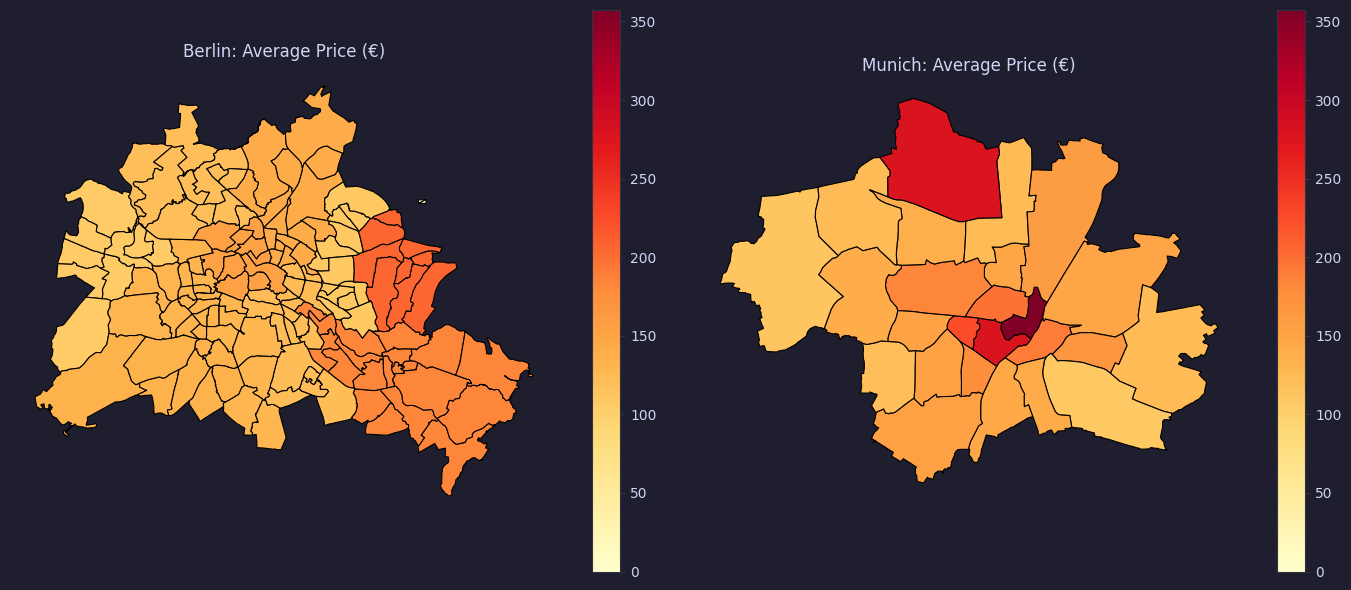

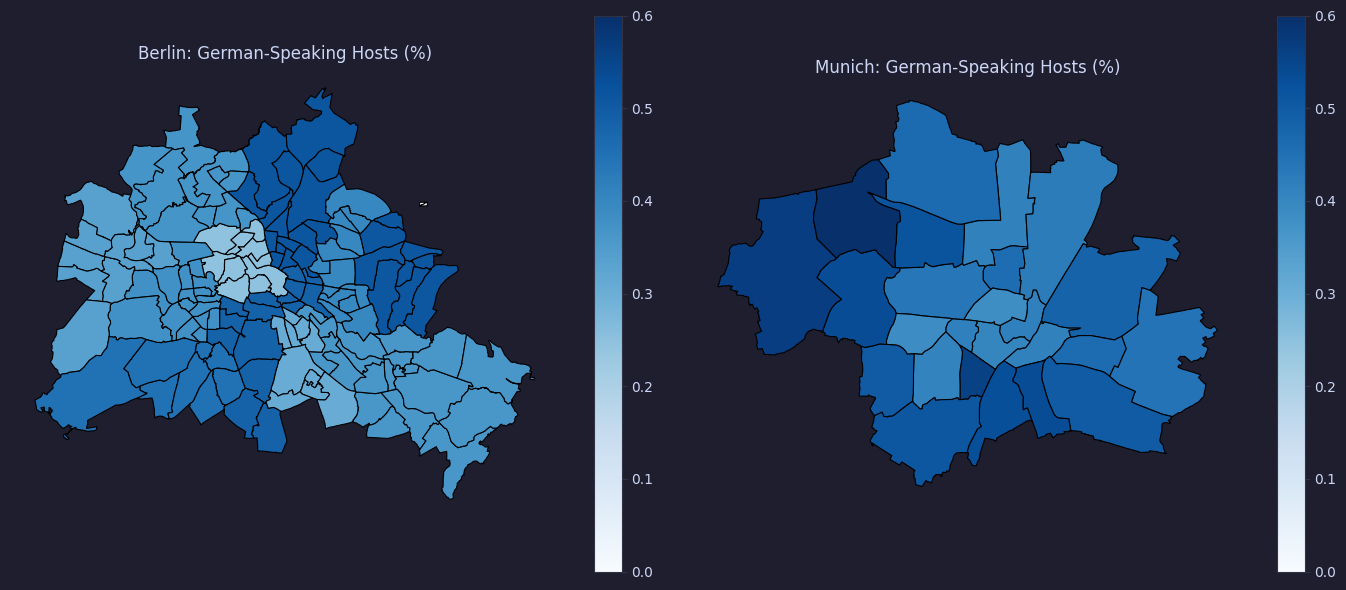

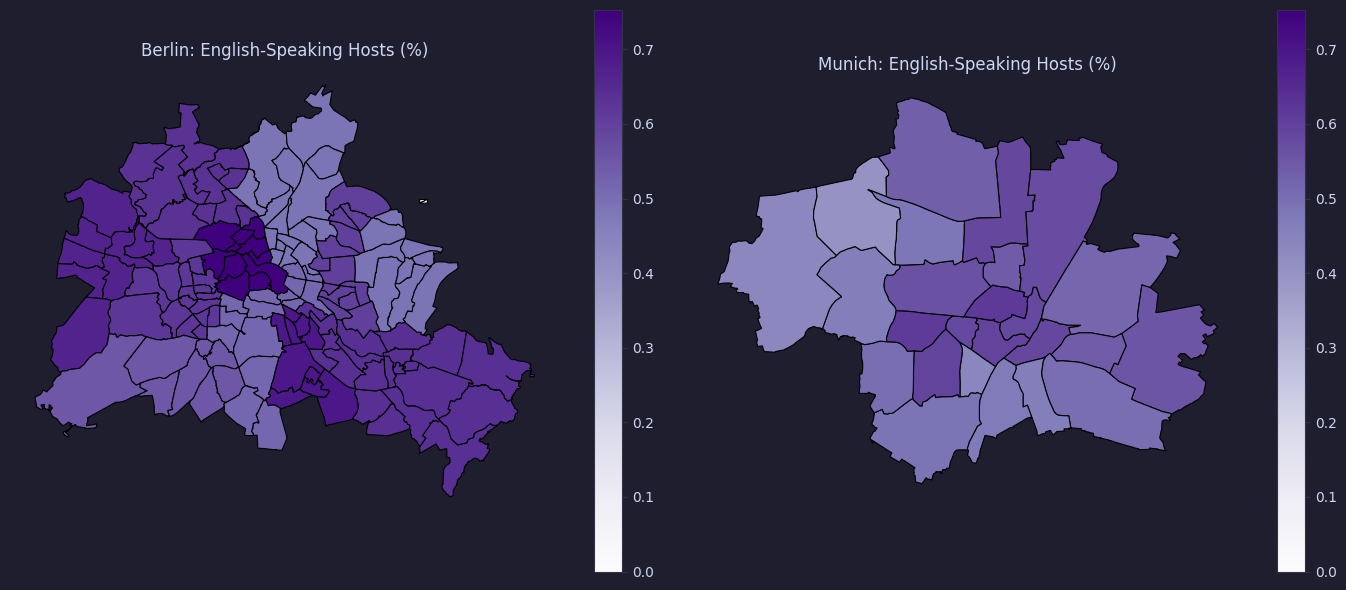

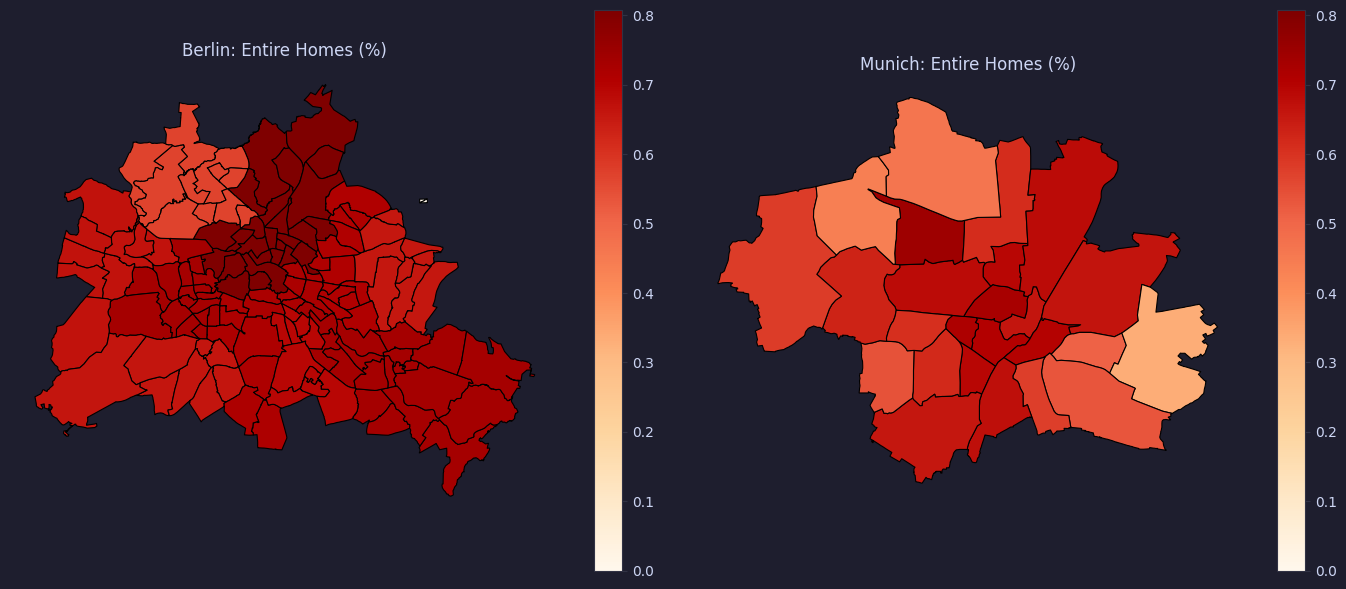

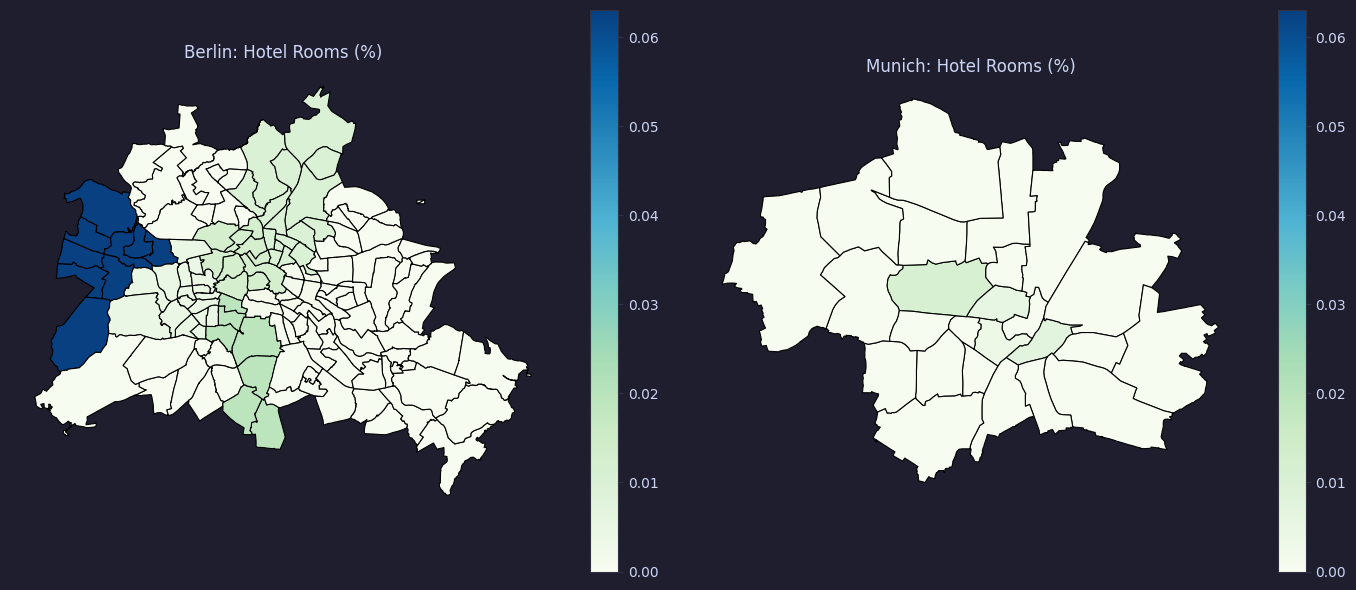

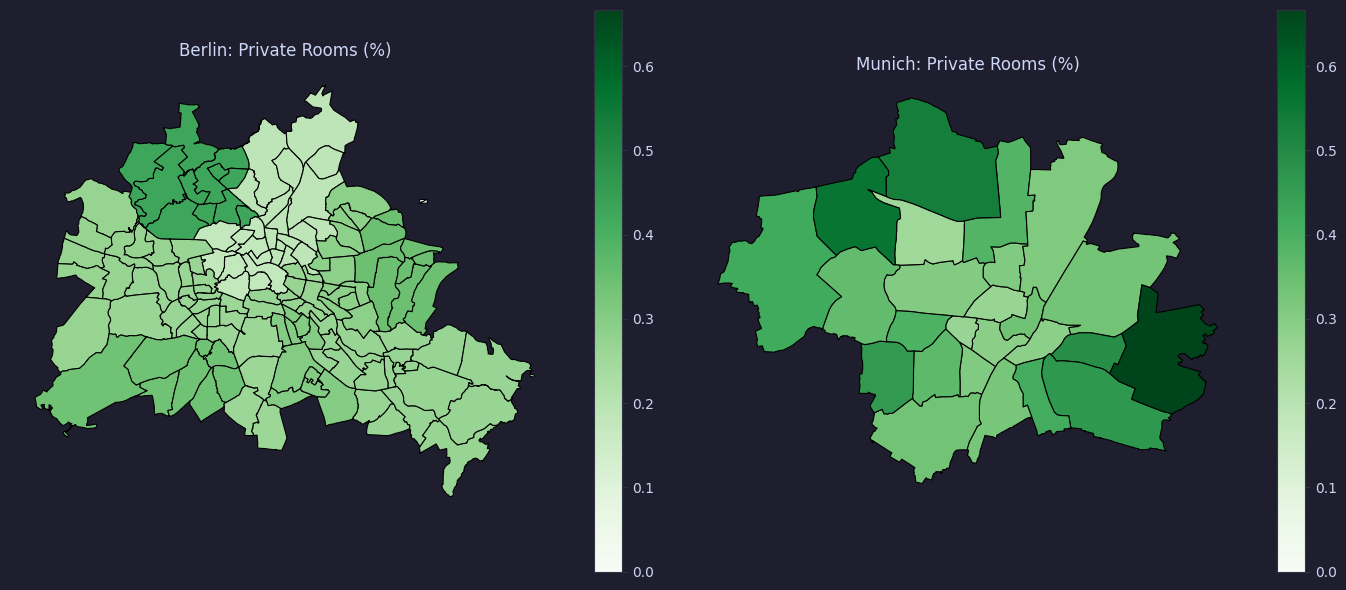

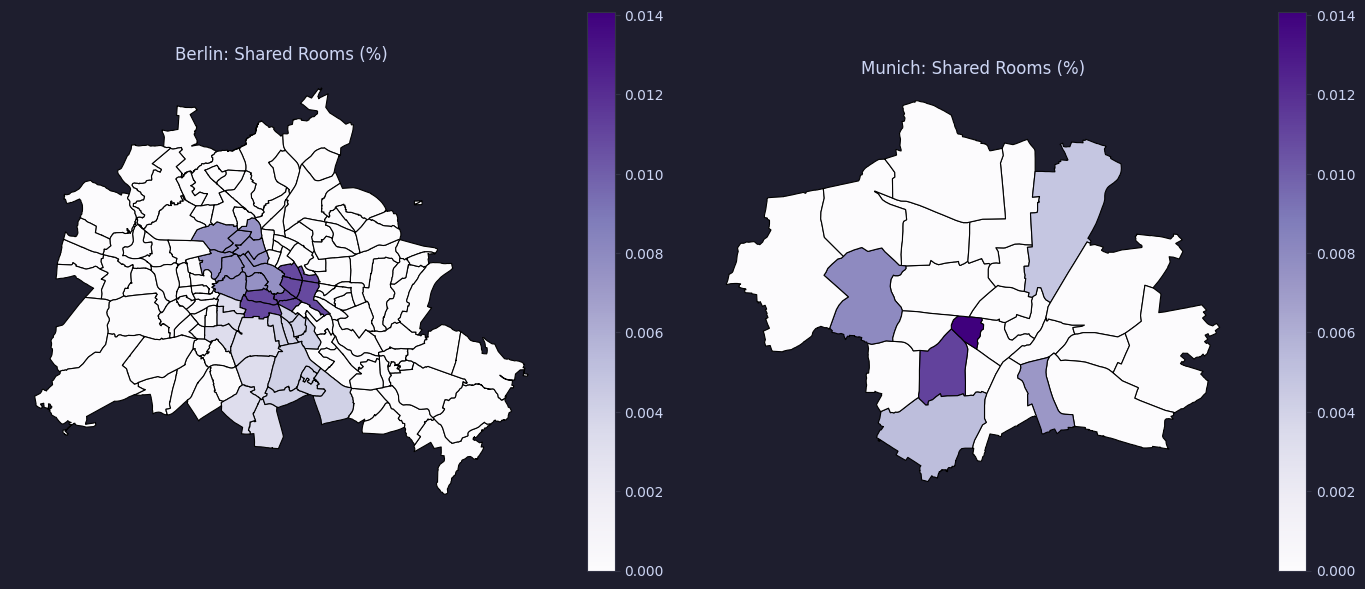

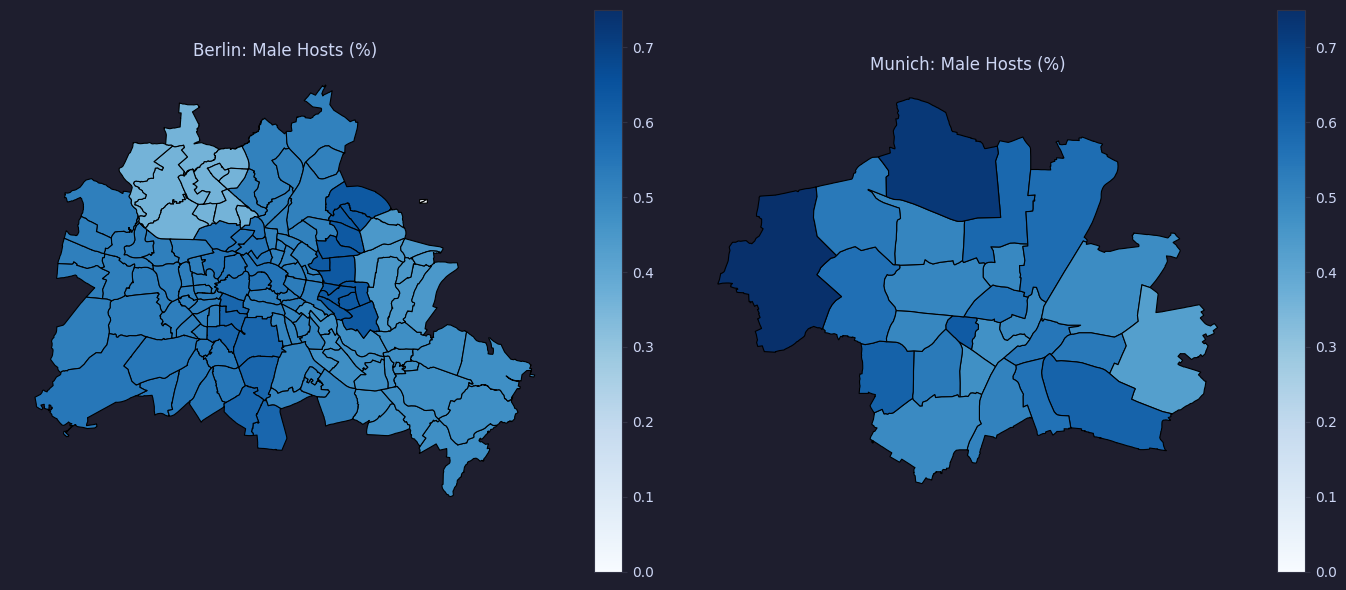

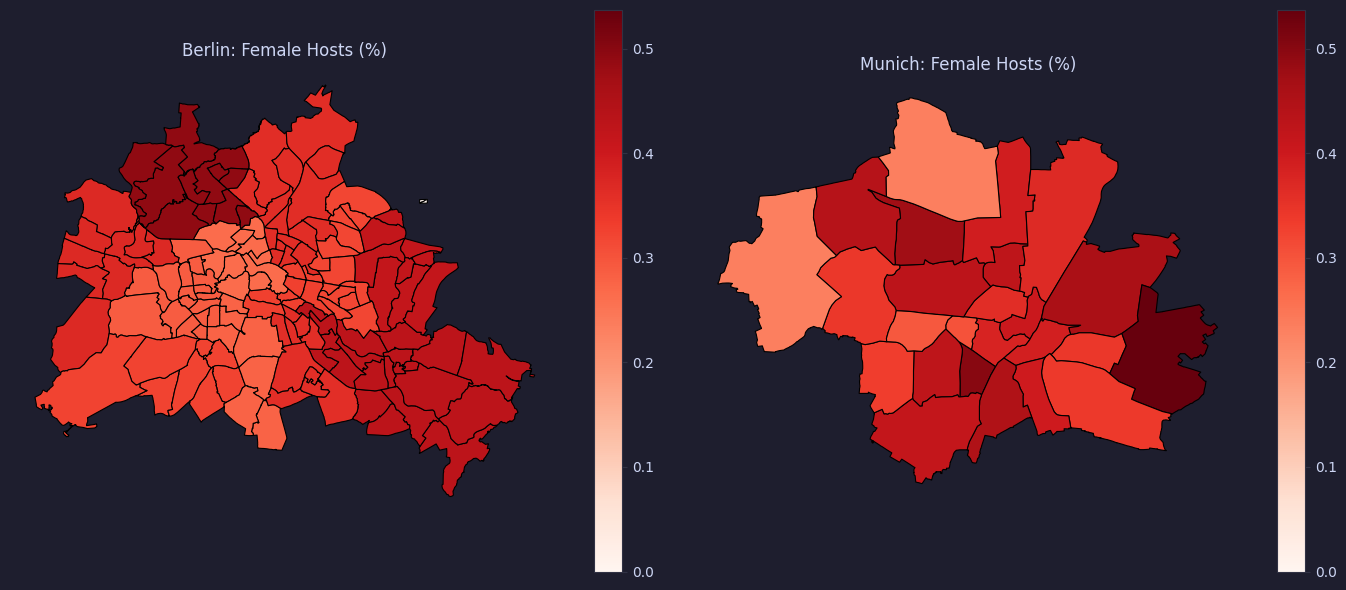

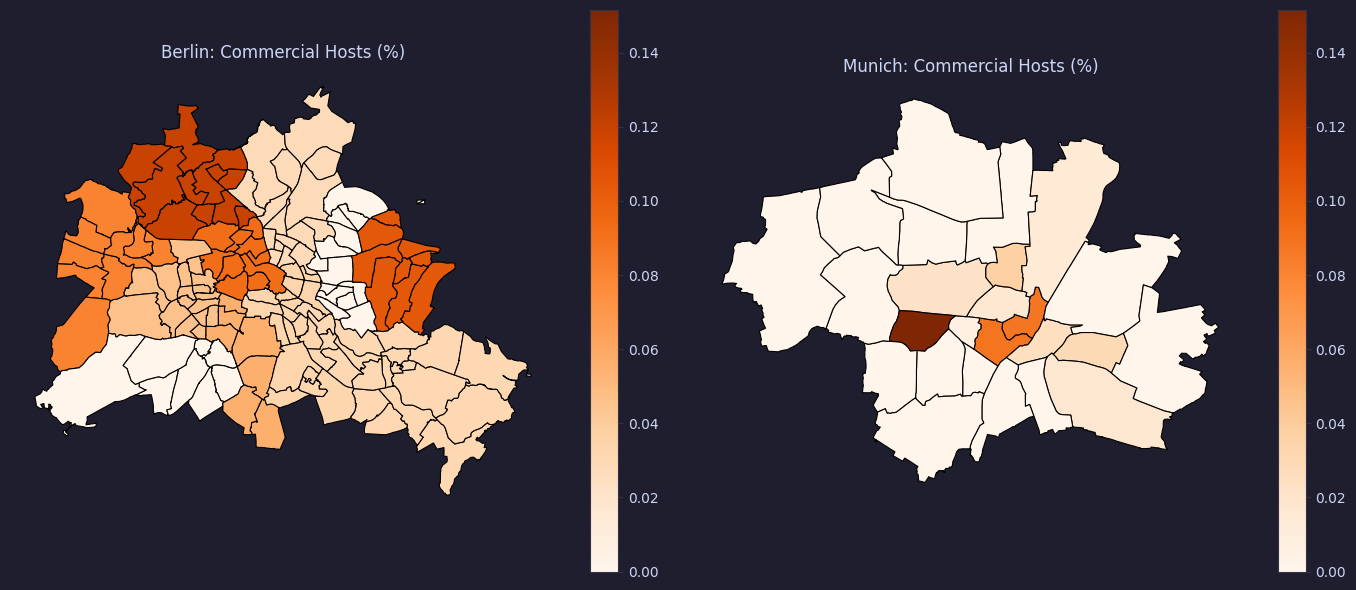

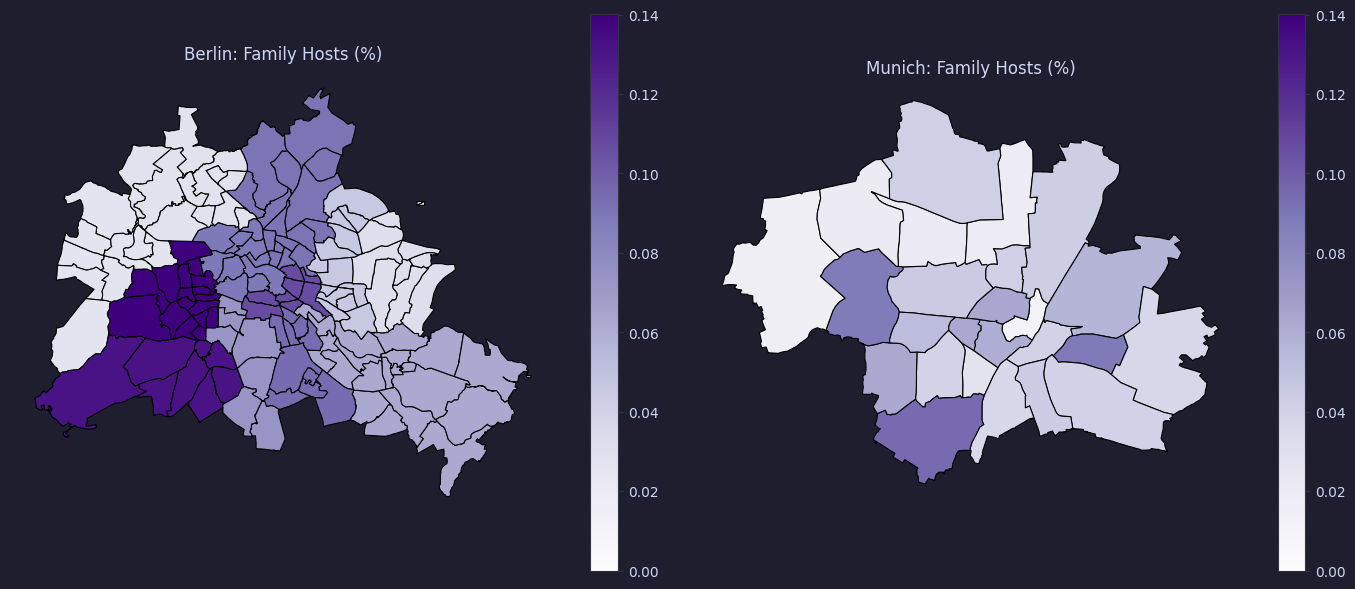

In [145]:
# Define a function to plot side-by-side choropleth maps with a shared color scale
def plot_choropleth(feature, title, cmap="YlOrRd"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Ensure feature exists in both datasets
    if feature not in geo_b.columns or feature not in geo_m.columns:
        print(f"Feature '{feature}' not found in one of the datasets!")
        return

    # Get min and max values across both cities for consistent color scaling
    all_values = np.concatenate([geo_b[feature].dropna(), geo_m[feature].dropna()])
    vmin, vmax = all_values.min(), all_values.max()

    # Plot Berlin
    geo_b.plot(column=feature, cmap=cmap, linewidth=0.8, edgecolor="black",
               ax=axes[0], legend=True, vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Berlin: {title}", fontsize=12)
    axes[0].axis("off")

    # Plot Munich
    geo_m.plot(column=feature, cmap=cmap, linewidth=0.8, edgecolor="black",
               ax=axes[1], legend=True, vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Munich: {title}", fontsize=12)
    axes[1].axis("off")

    # Show the figure
    plt.tight_layout()
    plt.show()

# Plot average price in Berlin vs Munich
plot_choropleth("price", "Average Price (€)")

# Compare language distribution
plot_choropleth("de", "German-Speaking Hosts (%)", cmap="Blues")
plot_choropleth("en", "English-Speaking Hosts (%)", cmap="Purples")

# Compare room type distribution
plot_choropleth("Entire home/apt", "Entire Homes (%)", cmap="OrRd")
plot_choropleth("Hotel room", "Hotel Rooms (%)", cmap="GnBu")
plot_choropleth("Private room", "Private Rooms (%)", cmap="Greens")
plot_choropleth("Shared room", "Shared Rooms (%)", cmap="Purples")

# Compare host type distribution
plot_choropleth("Male", "Male Hosts (%)", cmap="Blues")
plot_choropleth("Female", "Female Hosts (%)", cmap="Reds")
plot_choropleth("Commercial", "Commercial Hosts (%)", cmap="Oranges")
plot_choropleth("Family", "Family Hosts (%)", cmap="Purples")